In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from matplotlib import colormaps

In [2]:
node_num=0
person_list=[]
class Person:
    def __init__(self, node=node_num, gender="female"):
        global node_num, person_list;
        self.name = node
        self.gender = gender
        self.father = None
        self.mother = None
        self.children = None
        self.husband = None
        self.wife = None
        print(self.name)
        node_num += 1
        person_list.append(self)
        
    def build(self):
        global node_num, person_list;
        if node_num >= max_node_num:
            return
        new_person_list = []
        if self.father is None:
            if np.random.rand(1) < p_parents:
                self.father = Person(node=node_num, gender="male")
                self.mother = Person(node=node_num, gender="female")
                self.father.wife = self.mother
                self.mother.husband = self.father
#                 self.father.build()
                new_person_list.append(self.father)
                if self.father.children is None:
                    self.father.children = [self]
                else:
                    self.father.children.append(self)
                self.mother.children = self.father.children
#                 self.mother.build()
                new_person_list.append(self.mother)
                
                
                

        if self.gender == "female" and self.husband is None:
            if np.random.rand(1) < p_couple:
                self.husband = Person(node=node_num, gender="male")
                self.husband.wife = self
                if self.children is None:
                    self.children = []
                num_children = min(np.random.geometric(p=p_child), 4)
                if num_children > len(self.children):
                    for _ in range(num_children-len(self.children)):
                        if np.random.rand(1) < 0.5:
                            gender = "female"
                        else:
                            gender = "male"
                        child = Person(node=node_num, gender=gender)
                        child.mother = self #switch to father if male
                        child.father = self.husband
#                         child.build()
                        new_person_list.append(child)
                        self.children.append(child)
                
                self.husband.children = self.children
                new_person_list.append(self.husband)
#                 self.husband.build()
        elif self.gender == "male" and self.wife is None:
            if np.random.rand(1) < p_couple:
                self.wife = Person(node=node_num, gender="female")
                self.wife.husband = self
                if self.children is None:
                    self.children = []
                num_children = min(np.random.geometric(p=p_child), 4)
                if num_children > len(self.children):
                    for _ in range(num_children-len(self.children)):
                        if np.random.rand(1) < 0.5:
                            gender = "female"
                        else:
                            gender = "male"
                        child = Person(node=node_num, gender=gender)
                        child.father = self #switch to father if male
                        child.mother = self.wife
#                         child.build()
                        new_person_list.append(child)
                        self.children.append(child)
                self.wife.children = self.children
                new_person_list.append(self.wife)
#                 self.wife.build()
        for person in new_person_list:
            person.build()


(edge_list, edge_type_list, fixed_names, person_list) = torch.load("synthetic_data/family-200-graph.pt")

/tmp/ipykernel_261838/931987202.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  (edge_list, edge_type_list, fixed_names, person_list) = torch.load("synthetic_data/famil

In [42]:
from copy import deepcopy
class Rule:
    def __init__(self, left_tuples, right_tuple):
        self.left_tuples = left_tuples
        self.right_tuple = right_tuple
        self.num_var = max(max(tup[0], tup[2]) for tup in left_tuples + [right_tuple]) + 1
        
    def get_up_edges_list(self, edge_list, edge_type_list, unlearn_edge, unlearn_edge_type):
        source_type_dict = {}
        type_target_dict = {}
        for edge, edge_type in zip(edge_list, edge_type_list):
            source_type = (edge[0], edge_type)
            if source_type in source_type_dict.keys():
                source_type_dict[source_type].append(edge[1])
            else:
                source_type_dict[source_type] = [edge[1]]
                
            type_target = (edge_type, edge[1])
            if type_target in type_target_dict.keys():
                type_target_dict[type_target].append(edge[0])
            else:
                type_target_dict[type_target] = [edge[0]]
        
        var_value = -np.ones(self.num_var)
        var_value[self.right_tuple[0]] = unlearn_edge[0]
        var_value[self.right_tuple[2]] = unlearn_edge[1]
        
        dc_var_value_list = []
        
        def _get_up_edges_list(cur_var_value):
            if (cur_var_value == -1).sum() == 0:
                for tup in self.left_tuples + [self.right_tuple]:
                    if (cur_var_value[tup[0]], tup[1]) not in source_type_dict.keys():
                        return
                    if cur_var_value[tup[2]] not in source_type_dict[(cur_var_value[tup[0]], tup[1])]:
                        return
                
                if not any(np.array_equal(cur_var_value, unique_arr) for unique_arr in dc_var_value_list):
                    dc_var_value_list.append(cur_var_value)
                return
            
            for tup in self.left_tuples:
                if cur_var_value[tup[0]] == -1 and cur_var_value[tup[2]] != -1:
                    if (tup[1], cur_var_value[tup[2]]) in type_target_dict.keys():
                        for potential_tup0_val in type_target_dict[(tup[1], cur_var_value[tup[2]])]:
                            new_cur_var_value = deepcopy(cur_var_value)
                            new_cur_var_value[tup[0]] = potential_tup0_val
                            _get_up_edges_list(new_cur_var_value)
                elif cur_var_value[tup[2]] == -1 and cur_var_value[tup[0]] != -1:
                    if (cur_var_value[tup[0]], tup[1]) in source_type_dict.keys():
                        for potential_tup0_val in source_type_dict[(cur_var_value[tup[0]], tup[1])]:
                            new_cur_var_value = deepcopy(cur_var_value)
                            new_cur_var_value[tup[2]] = potential_tup0_val
                            _get_up_edges_list(new_cur_var_value)
        
        _get_up_edges_list(var_value)
        
        up_edges_list = []
        for dc_var_value in dc_var_value_list:
            up_edges = []
            for tup in self.left_tuples:
                up_edges.append((dc_var_value[tup[0]], tup[1], dc_var_value[tup[2]]))
            up_edges_list.append(up_edges)
            
        return up_edges_list
    
    def get_dc_edges_list(self, edge_list, edge_type_list):
        source_type_dict = {}
        type_target_dict = {}
        for edge, edge_type in zip(edge_list, edge_type_list):
            source_type = (edge[0], edge_type)
            if source_type in source_type_dict.keys():
                source_type_dict[source_type].append(edge[1])
            else:
                source_type_dict[source_type] = [edge[1]]
                
            type_target = (edge_type, edge[1])
            if type_target in type_target_dict.keys():
                type_target_dict[type_target].append(edge[0])
            else:
                type_target_dict[type_target] = [edge[0]]
        
        dc_var_value_list = []
        def _get_right_edges_list(cur_var_value):
            if (cur_var_value == -1).sum() == 0:
                for tup in self.left_tuples:
                    if (cur_var_value[tup[0]], tup[1]) not in source_type_dict.keys():
                        return
                    if cur_var_value[tup[2]] not in source_type_dict[(cur_var_value[tup[0]], tup[1])]:
                        return
                if not any(np.array_equal(cur_var_value, unique_arr) for unique_arr in dc_var_value_list):
                    dc_var_value_list.append(cur_var_value)
                return
            
            for tup in self.left_tuples:
                if cur_var_value[tup[0]] == -1 and cur_var_value[tup[2]] != -1:
                    if (tup[1], cur_var_value[tup[2]]) in type_target_dict.keys():
                        for potential_tup0_val in type_target_dict[(tup[1], cur_var_value[tup[2]])]:
                            new_cur_var_value = deepcopy(cur_var_value)
                            new_cur_var_value[tup[0]] = potential_tup0_val
                            _get_right_edges_list(new_cur_var_value)
                elif cur_var_value[tup[2]] == -1 and cur_var_value[tup[0]] != -1:
                    if (cur_var_value[tup[0]], tup[1]) in source_type_dict.keys():
                        for potential_tup0_val in source_type_dict[(cur_var_value[tup[0]], tup[1])]:
                            new_cur_var_value = deepcopy(cur_var_value)
                            new_cur_var_value[tup[2]] = potential_tup0_val
                            _get_right_edges_list(new_cur_var_value)
        
        for edge, edge_type in tqdm(zip(edge_list, edge_type_list)):
            if edge_type == self.left_tuples[0][1]:
                var_value = -np.ones(self.num_var)
                var_value[self.left_tuples[0][0]] = edge[0]
                var_value[self.left_tuples[0][2]] = edge[1]
                _get_right_edges_list(var_value)
        
        
        new_edge_list = []
        new_edge_type_list = []
        
        for dc_var_value in dc_var_value_list:
            new_edge = (dc_var_value[self.right_tuple[0]], dc_var_value[self.right_tuple[2]])
            new_edge_type = (self.right_tuple[1])
            
            if (dc_var_value[self.right_tuple[0]], self.right_tuple[1]) in source_type_dict.keys():
                if dc_var_value[self.right_tuple[2]] in source_type_dict[(dc_var_value[self.right_tuple[0]], self.right_tuple[1])]:
                    continue
            
            if self.right_tuple[1] in ["husband", "uncle", "father", "brother", "nephew"]:
                if person_list[int(dc_var_value[self.right_tuple[2]])].gender != "male":
                    continue
                if self.right_tuple[1] == "husband" and person_list[int(dc_var_value[self.right_tuple[0]])].gender != "female":
                    continue
                    
            elif self.right_tuple[1] in ["wife", "aunt", "mother", "sister", "niece"]:
                if person_list[int(dc_var_value[self.right_tuple[2]])].gender != "female":
                    continue
                if self.right_tuple[1] == "wife" and person_list[int(dc_var_value[self.right_tuple[0]])].gender != "male":
                    continue
            if dc_var_value[self.right_tuple[0]] == dc_var_value[self.right_tuple[2]]:
                continue
            
            print([((dc_var_value[left_tuple[0]], dc_var_value[left_tuple[2]]), left_tuple[1]) for left_tuple in self.left_tuples])
            print(new_edge, new_edge_type)
            new_edge_list.append(new_edge)
            new_edge_type_list.append(new_edge_type)
            
        return new_edge_list, new_edge_type_list
    
def check_valid_unlearn(minimal_set, unlearn_data_id, edge_list, edge_type_list, rule_list):
    def _check_valid_unlearn(cur_unlearn_data_id, minimal_set_verified, rec=0):
#         print(rec, minimal_set_verified)
        unlearn_edge = edge_list[cur_unlearn_data_id]
        unlearn_edge_type = edge_type_list[cur_unlearn_data_id]
        rule_set_related = [rule for rule in rule_list if rule.right_tuple[1] == unlearn_edge_type]

        for rule in rule_set_related:
            up_edges_list = rule.get_up_edges_list(edge_list, edge_type_list, unlearn_edge, unlearn_edge_type)
            for up_edges in up_edges_list:
                if_suf = False
                for up_edge in up_edges:
                    ind = get_edge_id((up_edge[0], up_edge[2]))
                    if ind in minimal_set:
                        if ind in minimal_set_verified:
                            if_suf = True
                            break
                        else:
                            minimal_set_verified.add(cur_unlearn_data_id)
                            if _check_valid_unlearn(ind, minimal_set_verified, rec=rec+1):
                                minimal_set_verified.remove(cur_unlearn_data_id)
                                if_suf = True
                                break
                            minimal_set_verified.remove(cur_unlearn_data_id)
                if not if_suf:
                    return False
        minimal_set_verified.add(cur_unlearn_data_id)
        return True
    if unlearn_data_id not in minimal_set:
        return False
    return _check_valid_unlearn(unlearn_data_id, set([]))
    

def check_if_in_deductive_closure(unlearn_data_id, minimal_set, edge_list, edge_type_list, rule_list):
    cur_minimal_set = set(deepcopy(minimal_set))
    
    new_added_id_list = []
    t = 0
    while len(new_added_id_list) > 0 or t == 0:
        new_added_id_list = []
        t = t + 1
        for cur_unlearn_data_id in cur_minimal_set:
            unlearn_edge = edge_list[cur_unlearn_data_id]
            unlearn_edge_type = edge_type_list[cur_unlearn_data_id]
            rule_set_related = [rule for rule in rule_list if rule.right_tuple[1] == unlearn_edge_type]
            if_deducted = False
            for rule in rule_set_related:
                if if_deducted:
                    break
                up_edges_list = rule.get_up_edges_list(edge_list, edge_type_list, unlearn_edge, unlearn_edge_type)
                for up_edges in up_edges_list:
                    up_edges_if_deducted = True
                    for up_edge in up_edges:
                        ind = get_edge_id((up_edge[0], up_edge[2]))
                        if ind in cur_minimal_set:
                            up_edges_if_deducted = False
                            break
                    if up_edges_if_deducted:
                        if_deducted = True
                        new_added_id_list.append(cur_unlearn_data_id)
                        break
        for new_added_id in new_added_id_list:
            cur_minimal_set.remove(new_added_id)
    if unlearn_data_id in cur_minimal_set:
        return False
    else:
        return True
                        
                
    
def get_minimal_nec_unlearn_and_not_included_unlearn(unlearn_data_id, edge_list, edge_type_list, rule_list, seed=0, search_unlearn_ind=None):
    np.random.seed(seed)
    random.seed(seed)
    nec_unlearn_ind = np.zeros(len(unlearn_ind))
    not_included_unlearn_ind = np.zeros(len(unlearn_ind))
    
    minimal_set = set([])
    if search_unlearn_ind[unlearn_data_id] == 1:
        nec_unlearn_ind[unlearn_data_id] = 1;
    else:
        not_included_unlearn_ind[unlearn_data_id] = 1
    minimal_set_unverified = set([unlearn_data_id])

    
    #Find a valid unlearning set expanded from the given unlearning result.
    while len(minimal_set_unverified) >= 1:
#         print(minimal_set_unverified)
        cur_unlearn_data_id = random.sample(sorted(minimal_set_unverified), 1)[0]
        minimal_set_unverified.remove(cur_unlearn_data_id)
        minimal_set.add(cur_unlearn_data_id)

        unlearn_edge = edge_list[cur_unlearn_data_id]
        unlearn_edge_type = edge_type_list[cur_unlearn_data_id]
        rule_set_related = [rule for rule in rule_list if rule.right_tuple[1] == unlearn_edge_type]

        for rule in rule_set_related:
            up_edges_list = rule.get_up_edges_list(edge_list, edge_type_list, unlearn_edge, unlearn_edge_type)
            for up_edges in up_edges_list:
                if_suf = 0
                for up_edge in up_edges:
                    ind = get_edge_id((up_edge[0], up_edge[2]))
                    if search_unlearn_ind[ind] == 1:
                        nec_unlearn_ind[ind] = 1;
                        if_suf = 1
                        if (ind not in minimal_set) and (ind not in minimal_set_unverified):
                            minimal_set_unverified.add(ind)
                        break
                    elif not_included_unlearn_ind[ind] == 1:
                        if_suf = 1
                        if (ind not in minimal_set) and (ind not in minimal_set_unverified):
                            minimal_set_unverified.add(ind)
                        break
                if if_suf == 0:
                    rand_edge = random.sample(up_edges, 1)[0]
                    rand_ind = get_edge_id((rand_edge[0], rand_edge[2]))
                    if (rand_ind not in minimal_set) and (rand_ind not in minimal_set_unverified):
                        minimal_set_unverified.add(rand_ind)
                    not_included_unlearn_ind[rand_ind] = 1
        
    #Prune the valid unlearning set by removing redundant element from the extended part
    minimal_set = set(minimal_set)
    
    C = []
    t = 0
    while len(C) != 0 or t==0:
        C = []
        t = t+1
        shuffled_minimal_set = np.asarray(list(minimal_set))[np.random.permutation(len(minimal_set))]
        for data_id in shuffled_minimal_set:
            minimal_set.remove(data_id)
            if not check_if_in_deductive_closure(unlearn_data_id, minimal_set, edge_list, edge_type_list, rule_list):
                C.append(data_id)
            else:
                minimal_set.add(data_id)
    return minimal_set
    
def get_prec_rec_acc(minimal_set, unlearn_ind):
    minimal_set_ind = np.zeros(len(unlearn_ind))
    minimal_set_ind[list(minimal_set)] = 1
    prec = (minimal_set_ind * unlearn_ind).sum() / max(unlearn_ind.sum(), 1e-8)
    rec = (minimal_set_ind * unlearn_ind).sum() / minimal_set_ind.sum()
    acc = 1 - (unlearn_ind * (1 - minimal_set_ind)).sum() / (len(unlearn_ind) - len(minimal_set))
    return prec, rec, acc
    
    
def get_valid_unlearn_general(unlearn_data_id, edge_list, edge_type_list, unlearn_ind, rule_list, num_seed=10, search_name="dynamic"):
    if search_name == "dynamic":
        minimal_unlearn_list = []
        search_unlearn_ind = deepcopy(unlearn_ind)
        for seed in range(num_seed):
            minimal_set = get_minimal_nec_unlearn_and_not_included_unlearn(unlearn_data_id, edge_list, edge_type_list, rule_list, seed, search_unlearn_ind)
            minimal_unlearn_list.append(minimal_set)
        minimal_unlearn_set = set([frozenset(minimal_set) for minimal_set in minimal_unlearn_list])
    else:
        if os.path.exists(f"synthetic_data/family-qa-200_unlearn_minimal_set/{unlearn_data_id}_new_2.pt"):
            minimal_unlearn_set = torch.load(f"synthetic_data/family-qa-200_unlearn_minimal_set/{unlearn_data_id}_new_2.pt")
        else:
            _, _, minimal_unlearn_list = get_valid_unlearn_general(unlearn_data_id, edge_list, edge_type_list, np.zeros(len(unlearn_ind)), rule_list, num_seed=100)
            minimal_unlearn_set = set([frozenset(minimal_set) for minimal_set in minimal_unlearn_list])
            torch.save(minimal_unlearn_set, f"synthetic_data/family-qa-200_unlearn_minimal_set/{unlearn_data_id}_new_2.pt")
    precision_list = []
    recall_list = []
    acc_list = []
    for minimal_set in minimal_unlearn_set:
        prec, rec, acc = get_prec_rec_acc(minimal_set, unlearn_ind)
        precision_list.append(prec)
        recall_list.append(rec)
        acc_list.append(acc)
    
    return precision_list, recall_list, acc_list, minimal_unlearn_set


def get_edge_id(edge):
    for i, _edge in enumerate(edge_list):
        if _edge == edge:
            return i

def get_valid_unlearn(unlearn_data_id):
    kg_ind = np.ones([len(edge_list)])
    if unlearn_data_id == 0:
        kg_ind[0] = 0
        kg_ind[3] = 0
        kg_ind[get_edge_id((1, 2))] = 0
        kg_ind[get_edge_id((2, 1))] = 0
        kg_ind[get_edge_id((0, 2))] = 0
        kg_ind[get_edge_id((2, 0))] = 0
    elif unlearn_data_id == 4:
        kg_ind[4] = 0
        kg_ind[get_edge_id((5, 3))] = 0
        kg_ind[get_edge_id((5, 2))] = 0
        kg_ind[get_edge_id((2, 5))] = 0
        kg_ind[get_edge_id((5, 4))] = 0
        kg_ind[get_edge_id((4, 5))] = 0
    elif unlearn_data_id == 6:
        kg_ind[6] = 0
        kg_ind[get_edge_id((2, 0))] = 0
        kg_ind[get_edge_id((1, 0))] = 0
        kg_ind[get_edge_id((0, 1))] = 0
    else:
        print(f"haven't implemented this unlearn_data_id {unlearn_data_id} yet")
    return kg_ind
        

In [43]:
rule_list = torch.load("synthetic_data/family_rule.pt")

/tmp/ipykernel_261838/3796601595.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rule_list = torch.load("synthetic_data/family_rule.pt")


In [44]:
print(person_list[1].gender)

male


In [45]:
def get_deductive_closure(edge_list, edge_type_list, rule_list):
    dc_edge_list, dc_edge_type_list = deepcopy(edge_list), deepcopy(edge_type_list)
    new_edge_list = []
    new_edge_type_list = []
    cur_iter=0
    while len(new_edge_list) > 0 or cur_iter == 0:
        print(f"---------iter: {cur_iter}---------")
        new_edge_list = []
        new_edge_type_list = []
        for rule in rule_list:
            _new_edge_list, _new_edge_type_list = rule.get_dc_edges_list(dc_edge_list, dc_edge_type_list)
            dc_edge_list = dc_edge_list + _new_edge_list
            dc_edge_type_list = dc_edge_type_list + _new_edge_type_list
            
            new_edge_list = new_edge_list + _new_edge_list
            new_edge_type_list = new_edge_type_list + _new_edge_type_list
            
        cur_iter += 1
    return dc_edge_list, dc_edge_type_list

In [46]:
dc_edge_list, dc_edge_type_list = get_deductive_closure(edge_list, edge_type_list, rule_list)

---------iter: 0---------


400it [00:00, 101287.23it/s]
400it [00:00, 4026.92it/s]
400it [00:00, 31599.68it/s]
400it [00:00, 108128.49it/s]
400it [00:00, 4026.69it/s]
400it [00:00, 31448.63it/s]
400it [00:00, 775287.25it/s]
400it [00:00, 487993.48it/s]
400it [00:00, 188847.55it/s]
400it [00:00, 171248.50it/s]
400it [00:00, 826871.17it/s]
400it [00:00, 472597.63it/s]
400it [00:00, 201964.80it/s]
400it [00:00, 169758.33it/s]
400it [00:00, 431069.27it/s]
400it [00:00, 1506033.75it/s]
400it [00:00, 194721.63it/s]
400it [00:00, 485873.62it/s]
400it [00:00, 1359579.90it/s]
400it [00:00, 170500.16it/s]
400it [00:00, 74163.27it/s]
400it [00:00, 148655.11it/s]
400it [00:00, 2267.04it/s]
400it [00:00, 5788.42it/s]


[((76.0, 79.0), 'mother'), ((80.0, 79.0), 'mother')]
(80.0, 76.0) brother
[((33.0, 32.0), 'mother'), ((29.0, 32.0), 'mother')]
(29.0, 33.0) brother
[((12.0, 11.0), 'mother'), ((7.0, 11.0), 'mother')]
(7.0, 12.0) brother
[((38.0, 36.0), 'mother'), ((34.0, 36.0), 'mother')]
(34.0, 38.0) brother
[((14.0, 11.0), 'mother'), ((7.0, 11.0), 'mother')]
(7.0, 14.0) brother
[((50.0, 49.0), 'mother'), ((46.0, 49.0), 'mother')]
(46.0, 50.0) brother
[((87.0, 92.0), 'mother'), ((93.0, 92.0), 'mother')]
(93.0, 87.0) brother
[((59.0, 54.0), 'mother'), ((52.0, 54.0), 'mother')]
(52.0, 59.0) brother
[((7.0, 11.0), 'mother'), ((12.0, 11.0), 'mother')]
(12.0, 7.0) brother
[((7.0, 11.0), 'mother'), ((15.0, 11.0), 'mother')]
(15.0, 7.0) brother
[((7.0, 11.0), 'mother'), ((14.0, 11.0), 'mother')]
(14.0, 7.0) brother
[((7.0, 11.0), 'mother'), ((13.0, 11.0), 'mother')]
(13.0, 7.0) brother
[((65.0, 62.0), 'mother'), ((60.0, 62.0), 'mother')]
(60.0, 65.0) brother
[((93.0, 92.0), 'mother'), ((87.0, 92.0), 'mother'

419it [00:00, 6003.47it/s]
419it [00:00, 41971.09it/s]


[((80.0, 76.0), 'brother')]
(76.0, 80.0) sister
[((34.0, 38.0), 'brother')]
(38.0, 34.0) sister
[((52.0, 59.0), 'brother')]
(59.0, 52.0) sister
[((15.0, 7.0), 'brother')]
(7.0, 15.0) sister
[((13.0, 7.0), 'brother')]
(7.0, 13.0) sister
[((60.0, 65.0), 'brother')]
(65.0, 60.0) sister
[((16.0, 21.0), 'brother')]
(21.0, 16.0) sister
[((86.0, 81.0), 'brother')]
(81.0, 86.0) sister
[((51.0, 46.0), 'brother')]
(46.0, 51.0) sister


428it [00:00, 102189.45it/s]
428it [00:00, 2981.97it/s]
428it [00:00, 6194.85it/s]


[((27.0, 24.0), 'mother'), ((22.0, 24.0), 'mother')]
(22.0, 27.0) sister
[((28.0, 24.0), 'mother'), ((22.0, 24.0), 'mother')]
(22.0, 28.0) sister
[((22.0, 24.0), 'mother'), ((27.0, 24.0), 'mother')]
(27.0, 22.0) sister
[((22.0, 24.0), 'mother'), ((28.0, 24.0), 'mother')]
(28.0, 22.0) sister


432it [00:00, 6252.42it/s]
432it [00:00, 14913.20it/s]
432it [00:00, 34875.84it/s]
432it [00:00, 38826.99it/s]
432it [00:00, 75775.31it/s]
432it [00:00, 17243.76it/s]
432it [00:00, 34673.62it/s]
432it [00:00, 38876.98it/s]
432it [00:00, 74861.15it/s]
432it [00:00, 38419.48it/s]


[((16.0, 18.0), 'mother')]
(18.0, 16.0) child
[((76.0, 79.0), 'mother')]
(79.0, 76.0) child
[((73.0, 75.0), 'mother')]
(75.0, 73.0) child
[((74.0, 77.0), 'mother')]
(77.0, 74.0) child
[((52.0, 54.0), 'mother')]
(54.0, 52.0) child
[((87.0, 92.0), 'mother')]
(92.0, 87.0) child
[((7.0, 11.0), 'mother')]
(11.0, 7.0) child
[((22.0, 24.0), 'mother')]
(24.0, 22.0) child
[((29.0, 32.0), 'mother')]
(32.0, 29.0) child
[((34.0, 36.0), 'mother')]
(36.0, 34.0) child
[((6.0, 8.0), 'mother')]
(8.0, 6.0) child
[((81.0, 85.0), 'mother')]
(85.0, 81.0) child
[((60.0, 62.0), 'mother')]
(62.0, 60.0) child
[((44.0, 47.0), 'mother')]
(47.0, 44.0) child
[((46.0, 49.0), 'mother')]
(49.0, 46.0) child


447it [00:00, 73362.57it/s]
447it [00:00, 37506.08it/s]
447it [00:00, 39975.56it/s]
447it [00:00, 29588.63it/s]


[((73.0, 74.0), 'father')]
(74.0, 73.0) child
[((74.0, 76.0), 'father')]
(76.0, 74.0) child
[((87.0, 91.0), 'father')]
(91.0, 87.0) child
[((52.0, 53.0), 'father')]
(53.0, 52.0) child
[((7.0, 10.0), 'father')]
(10.0, 7.0) child
[((44.0, 46.0), 'father')]
(46.0, 44.0) child
[((46.0, 48.0), 'father')]
(48.0, 46.0) child
[((22.0, 23.0), 'father')]
(23.0, 22.0) child
[((29.0, 31.0), 'father')]
(31.0, 29.0) child
[((76.0, 78.0), 'father')]
(78.0, 76.0) child
[((34.0, 35.0), 'father')]
(35.0, 34.0) child
[((60.0, 61.0), 'father')]
(61.0, 60.0) child
[((6.0, 7.0), 'father')]
(7.0, 6.0) child
[((81.0, 84.0), 'father')]
(84.0, 81.0) child
[((16.0, 17.0), 'father')]
(17.0, 16.0) child


462it [00:00, 76278.08it/s]
462it [00:00, 41722.69it/s]
462it [00:00, 23778.63it/s]
462it [00:00, 11932.66it/s]
462it [00:00, 38805.04it/s]


---------iter: 1---------


462it [00:00, 129253.50it/s]
462it [00:00, 2733.01it/s]
462it [00:00, 36764.92it/s]
462it [00:00, 126189.66it/s]
462it [00:00, 2770.76it/s]
462it [00:00, 37037.57it/s]
462it [00:00, 817623.82it/s]
462it [00:00, 515089.96it/s]
462it [00:00, 78665.55it/s]


[((52.0, 58.0), 'child'), ((52.0, 59.0), 'brother')]
(59.0, 58.0) nephew
[((50.0, 56.0), 'child'), ((50.0, 46.0), 'brother')]
(46.0, 56.0) nephew
[((87.0, 88.0), 'child'), ((87.0, 93.0), 'brother')]
(93.0, 88.0) nephew
[((80.0, 83.0), 'child'), ((80.0, 76.0), 'brother')]
(76.0, 83.0) nephew
[((52.0, 56.0), 'child'), ((52.0, 59.0), 'brother')]
(59.0, 56.0) nephew
[((29.0, 30.0), 'child'), ((29.0, 33.0), 'brother')]
(33.0, 30.0) nephew
[((60.0, 63.0), 'child'), ((60.0, 65.0), 'brother')]
(65.0, 63.0) nephew
[((86.0, 90.0), 'child'), ((86.0, 81.0), 'brother')]
(81.0, 90.0) nephew
[((80.0, 82.0), 'child'), ((80.0, 76.0), 'brother')]
(76.0, 82.0) nephew
[((87.0, 90.0), 'child'), ((87.0, 93.0), 'brother')]
(93.0, 90.0) nephew
[((50.0, 58.0), 'child'), ((50.0, 46.0), 'brother')]
(46.0, 58.0) nephew
[((86.0, 88.0), 'child'), ((86.0, 81.0), 'brother')]
(81.0, 88.0) nephew
[((46.0, 44.0), 'child'), ((46.0, 50.0), 'brother')]
(50.0, 44.0) nephew


475it [00:00, 91988.84it/s]


[((81.0, 82.0), 'child'), ((81.0, 86.0), 'sister')]
(86.0, 82.0) nephew
[((38.0, 41.0), 'child'), ((38.0, 34.0), 'sister')]
(34.0, 41.0) nephew
[((38.0, 43.0), 'child'), ((38.0, 34.0), 'sister')]
(34.0, 43.0) nephew
[((81.0, 83.0), 'child'), ((81.0, 86.0), 'sister')]
(86.0, 83.0) nephew
[((27.0, 30.0), 'child'), ((27.0, 22.0), 'sister')]
(22.0, 30.0) nephew
[((65.0, 67.0), 'child'), ((65.0, 60.0), 'sister')]
(60.0, 67.0) nephew
[((59.0, 63.0), 'child'), ((59.0, 52.0), 'sister')]
(52.0, 63.0) nephew
[((38.0, 42.0), 'child'), ((38.0, 34.0), 'sister')]
(34.0, 42.0) nephew
[((76.0, 74.0), 'child'), ((76.0, 80.0), 'sister')]
(80.0, 74.0) nephew
[((46.0, 44.0), 'child'), ((46.0, 51.0), 'sister')]
(51.0, 44.0) nephew


485it [00:00, 751750.72it/s]
485it [00:00, 539013.63it/s]
485it [00:00, 82813.77it/s]


[((16.0, 20.0), 'child'), ((16.0, 21.0), 'brother')]
(21.0, 20.0) niece
[((86.0, 89.0), 'child'), ((86.0, 81.0), 'brother')]
(81.0, 89.0) niece
[((12.0, 19.0), 'child'), ((12.0, 7.0), 'brother')]
(7.0, 19.0) niece
[((87.0, 89.0), 'child'), ((87.0, 93.0), 'brother')]
(93.0, 89.0) niece
[((34.0, 37.0), 'child'), ((34.0, 38.0), 'brother')]
(38.0, 37.0) niece
[((33.0, 37.0), 'child'), ((33.0, 29.0), 'brother')]
(29.0, 37.0) niece
[((50.0, 57.0), 'child'), ((50.0, 46.0), 'brother')]
(46.0, 57.0) niece
[((93.0, 96.0), 'child'), ((93.0, 87.0), 'brother')]
(87.0, 96.0) niece
[((52.0, 57.0), 'child'), ((52.0, 59.0), 'brother')]
(59.0, 57.0) niece
[((50.0, 55.0), 'child'), ((50.0, 46.0), 'brother')]
(46.0, 55.0) niece
[((12.0, 20.0), 'child'), ((12.0, 7.0), 'brother')]
(7.0, 20.0) niece
[((52.0, 55.0), 'child'), ((52.0, 59.0), 'brother')]
(59.0, 55.0) niece
[((93.0, 95.0), 'child'), ((93.0, 87.0), 'brother')]
(87.0, 95.0) niece
[((60.0, 64.0), 'child'), ((60.0, 65.0), 'brother')]
(65.0, 64.0) ni

502it [00:00, 97020.58it/s]


[((21.0, 26.0), 'child'), ((21.0, 16.0), 'sister')]
(16.0, 26.0) niece
[((38.0, 40.0), 'child'), ((38.0, 34.0), 'sister')]
(34.0, 40.0) niece
[((59.0, 64.0), 'child'), ((59.0, 52.0), 'sister')]
(52.0, 64.0) niece
[((22.0, 25.0), 'child'), ((22.0, 27.0), 'sister')]
(27.0, 25.0) niece
[((22.0, 25.0), 'child'), ((22.0, 28.0), 'sister')]
(28.0, 25.0) niece
[((22.0, 26.0), 'child'), ((22.0, 27.0), 'sister')]
(27.0, 26.0) niece
[((22.0, 26.0), 'child'), ((22.0, 28.0), 'sister')]
(28.0, 26.0) niece
[((21.0, 25.0), 'child'), ((21.0, 16.0), 'sister')]
(16.0, 25.0) niece
[((7.0, 6.0), 'child'), ((7.0, 15.0), 'sister')]
(15.0, 6.0) niece
[((7.0, 6.0), 'child'), ((7.0, 13.0), 'sister')]
(13.0, 6.0) niece


512it [00:00, 116256.15it/s]


[((21.0, 20.0), 'niece')]
(20.0, 21.0) uncle
[((81.0, 89.0), 'niece')]
(89.0, 81.0) uncle
[((7.0, 19.0), 'niece')]
(19.0, 7.0) uncle
[((93.0, 89.0), 'niece')]
(89.0, 93.0) uncle
[((38.0, 37.0), 'niece')]
(37.0, 38.0) uncle
[((29.0, 37.0), 'niece')]
(37.0, 29.0) uncle
[((46.0, 57.0), 'niece')]
(57.0, 46.0) uncle
[((87.0, 96.0), 'niece')]
(96.0, 87.0) uncle
[((59.0, 57.0), 'niece')]
(57.0, 59.0) uncle
[((46.0, 55.0), 'niece')]
(55.0, 46.0) uncle
[((7.0, 20.0), 'niece')]
(20.0, 7.0) uncle
[((59.0, 55.0), 'niece')]
(55.0, 59.0) uncle
[((87.0, 95.0), 'niece')]
(95.0, 87.0) uncle
[((65.0, 64.0), 'niece')]
(64.0, 65.0) uncle
[((21.0, 19.0), 'niece')]
(19.0, 21.0) uncle
[((12.0, 6.0), 'niece')]
(6.0, 12.0) uncle
[((14.0, 6.0), 'niece')]
(6.0, 14.0) uncle


529it [00:00, 1485131.74it/s]
529it [00:00, 88574.32it/s]


[((52.0, 58.0), 'child'), ((52.0, 59.0), 'brother')]
(58.0, 59.0) uncle
[((50.0, 56.0), 'child'), ((50.0, 46.0), 'brother')]
(56.0, 46.0) uncle
[((87.0, 88.0), 'child'), ((87.0, 93.0), 'brother')]
(88.0, 93.0) uncle
[((80.0, 83.0), 'child'), ((80.0, 76.0), 'brother')]
(83.0, 76.0) uncle
[((52.0, 56.0), 'child'), ((52.0, 59.0), 'brother')]
(56.0, 59.0) uncle
[((29.0, 30.0), 'child'), ((29.0, 33.0), 'brother')]
(30.0, 33.0) uncle
[((60.0, 63.0), 'child'), ((60.0, 65.0), 'brother')]
(63.0, 65.0) uncle
[((86.0, 90.0), 'child'), ((86.0, 81.0), 'brother')]
(90.0, 81.0) uncle
[((80.0, 82.0), 'child'), ((80.0, 76.0), 'brother')]
(82.0, 76.0) uncle
[((87.0, 90.0), 'child'), ((87.0, 93.0), 'brother')]
(90.0, 93.0) uncle
[((50.0, 58.0), 'child'), ((50.0, 46.0), 'brother')]
(58.0, 46.0) uncle
[((86.0, 88.0), 'child'), ((86.0, 81.0), 'brother')]
(88.0, 81.0) uncle
[((46.0, 44.0), 'child'), ((46.0, 50.0), 'brother')]
(44.0, 50.0) uncle


542it [00:00, 120008.06it/s]


[((16.0, 26.0), 'niece')]
(26.0, 16.0) aunt
[((34.0, 40.0), 'niece')]
(40.0, 34.0) aunt
[((52.0, 64.0), 'niece')]
(64.0, 52.0) aunt
[((27.0, 25.0), 'niece')]
(25.0, 27.0) aunt
[((28.0, 25.0), 'niece')]
(25.0, 28.0) aunt
[((27.0, 26.0), 'niece')]
(26.0, 27.0) aunt
[((28.0, 26.0), 'niece')]
(26.0, 28.0) aunt
[((16.0, 25.0), 'niece')]
(25.0, 16.0) aunt
[((15.0, 6.0), 'niece')]
(6.0, 15.0) aunt
[((13.0, 6.0), 'niece')]
(6.0, 13.0) aunt


552it [00:00, 1511263.58it/s]
552it [00:00, 105253.25it/s]


[((81.0, 82.0), 'child'), ((81.0, 86.0), 'sister')]
(82.0, 86.0) aunt
[((38.0, 41.0), 'child'), ((38.0, 34.0), 'sister')]
(41.0, 34.0) aunt
[((38.0, 43.0), 'child'), ((38.0, 34.0), 'sister')]
(43.0, 34.0) aunt
[((81.0, 83.0), 'child'), ((81.0, 86.0), 'sister')]
(83.0, 86.0) aunt
[((27.0, 30.0), 'child'), ((27.0, 22.0), 'sister')]
(30.0, 22.0) aunt
[((65.0, 67.0), 'child'), ((65.0, 60.0), 'sister')]
(67.0, 60.0) aunt
[((59.0, 63.0), 'child'), ((59.0, 52.0), 'sister')]
(63.0, 52.0) aunt
[((38.0, 42.0), 'child'), ((38.0, 34.0), 'sister')]
(42.0, 34.0) aunt
[((76.0, 74.0), 'child'), ((76.0, 80.0), 'sister')]
(74.0, 80.0) aunt
[((46.0, 44.0), 'child'), ((46.0, 51.0), 'sister')]
(44.0, 51.0) aunt


562it [00:00, 40747.44it/s]
562it [00:00, 110077.47it/s]
562it [00:00, 2071.80it/s]
562it [00:00, 8133.66it/s]
562it [00:00, 8167.87it/s]
562it [00:00, 55707.30it/s]
562it [00:00, 111383.02it/s]
562it [00:00, 2051.48it/s]
562it [00:00, 8170.84it/s]
562it [00:00, 8227.51it/s]
562it [00:00, 11499.71it/s]
562it [00:00, 41668.71it/s]
562it [00:00, 50352.43it/s]
562it [00:00, 96792.96it/s]
562it [00:00, 13484.35it/s]
562it [00:00, 45025.10it/s]
562it [00:00, 50229.04it/s]
562it [00:00, 96996.08it/s]
562it [00:00, 49966.06it/s]
562it [00:00, 91676.99it/s]
562it [00:00, 46821.84it/s]
562it [00:00, 50640.17it/s]
562it [00:00, 37047.15it/s]
562it [00:00, 91191.10it/s]
562it [00:00, 49894.14it/s]
562it [00:00, 28702.57it/s]
562it [00:00, 14436.72it/s]
562it [00:00, 46763.32it/s]


---------iter: 2---------


562it [00:00, 151842.23it/s]
562it [00:00, 3339.42it/s]
562it [00:00, 44003.04it/s]
562it [00:00, 150947.67it/s]
562it [00:00, 3248.46it/s]
562it [00:00, 44392.53it/s]
562it [00:00, 144083.06it/s]
562it [00:00, 174723.80it/s]
562it [00:00, 94439.06it/s]
562it [00:00, 107286.83it/s]
562it [00:00, 143042.59it/s]
562it [00:00, 172284.67it/s]
562it [00:00, 95479.54it/s]
562it [00:00, 107379.69it/s]
562it [00:00, 126080.38it/s]
562it [00:00, 1440830.59it/s]
562it [00:00, 94640.01it/s]
562it [00:00, 124792.15it/s]
562it [00:00, 1477867.62it/s]
562it [00:00, 107428.62it/s]
562it [00:00, 55312.53it/s]
562it [00:00, 110869.61it/s]
562it [00:00, 2034.73it/s]
562it [00:00, 8164.73it/s]
562it [00:00, 8165.01it/s]
562it [00:00, 55347.60it/s]
562it [00:00, 110734.20it/s]
562it [00:00, 1390.22it/s]
562it [00:00, 7602.40it/s]
562it [00:00, 8164.59it/s]
562it [00:00, 11488.28it/s]
562it [00:00, 45137.18it/s]
562it [00:00, 49816.11it/s]
562it [00:00, 95719.92it/s]
562it [00:00, 12197.22it/s]
562it [00:0

In [53]:
# from tqdm import tqdm
# min_minimal_set_size_list = []
# for unlearn_data_id in tqdm(range(len(edge_list))):
#     _, _, _, minimal_unlearn_list = get_valid_unlearn_general(unlearn_data_id, edge_list, edge_type_list, np.zeros(len(edge_list)), rule_list, num_seed=50)
#     minimal_unlearn_set = set([frozenset(minimal_set) for minimal_set in minimal_unlearn_list])
#     torch.save(minimal_unlearn_set, f"synthetic_data/family-qa-200_unlearn_minimal_set/{unlearn_data_id}_new_2.pt")
    
# #     minimal_unlearn_set = torch.load(f"synthetic_data/family-qa-200_unlearn_minimal_set/{unlearn_data_id}.pt")
# #     min_minimal_set_size = min(len(_minimal_unlearn_set) for _minimal_unlearn_set in minimal_unlearn_set)
# #     min_minimal_set_size_list.append(min_minimal_set_size)
# #     torch.save(minimal_unlearn_set, f"synthetic_data/family-qa-200_unlearn_minimal_set/{unlearn_data_id}.pt")

In [54]:
# from tqdm import tqdm
# min_minimal_set_size_list = []
# for unlearn_data_id in tqdm(range(len(edge_list))):
#     minimal_unlearn_set = torch.load(f"synthetic_data/family-qa-200_unlearn_minimal_set/{unlearn_data_id}.pt")
#     min_minimal_set_size = min(len(_minimal_unlearn_set) for _minimal_unlearn_set in minimal_unlearn_set)
#     min_minimal_set_size_list.append(min_minimal_set_size)
# #     torch.save(minimal_unlearn_set, f"synthetic_data/family-qa-200_unlearn_minimal_set/{unlearn_data_id}.pt")

In [55]:
shuffled_edge_id_list = torch.load("synthetic_data/family-200-subsample50.pt")

/tmp/ipykernel_261838/4208419417.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  shuffled_edge_id_list = torch.load("synthetic_data/family-200-subsample50.pt")


In [34]:
#Fix the checkpoint
from sklearn.metrics import auc
import matplotlib.colors as colors

model_name_list = ["gpt2-xl", "phi", "llama2-7b", "llama3-8b"] #, ] #] #, ] #, #, , 
unlearn_method_name_list = ["grad_ascent", "npo", "tv", "whp"]#[]# "tv" "whp", [, ] #"whp",, ], , ,  , "npo", "tv"

# model_name_list = ["gpt2-xl"] #, ] #] #, ] #, #, , 
# unlearn_method_name_list = ["whp"]#[]# "tv" "whp", [, ] #"whp",, ], , ,  , "npo", "tv"


unlearn_data_id_list = range(55)#range(5) #range(5)

eval_name = "correct_rephrase"
att_eval_name = "attribtues_correct_rephrase"
y_axis_list = ["Accuracy", "Precision"]

search_name_list = ["greedy"] #"dynamic", 

result_dict = {}

save_dir = "/data/ruihan/llm_unlearning/checkpoint_prec_rec"
for model_name in model_name_list:
    if model_name == "phi" or model_name == "gpt2-xl":
        ft_lr = 2e-05
    else:
        ft_lr = 1e-05
    
    if model_name == "gpt2-xl":
        ft_num_epochs = 15
        iteration = 656
        num_epochs=32
    else:
        ft_num_epochs = 10
        iteration = 437
        num_epochs=16
        
    for unlearn_method_name in unlearn_method_name_list:
        for unlearn_data_id in tqdm(unlearn_data_id_list):
            #FIX THIS WHEN THE BUT IS FIXED
            shuffled_unlearn_data_id = shuffled_edge_id_list[unlearn_data_id]
            for search_name in search_name_list:
                if unlearn_method_name in ["grad_ascent", "npo"]:
                    step_id_list = list(range(1, num_epochs+1))
                    if unlearn_method_name == "grad_ascent":
                        lr = ft_lr
                    else:
                        lr = ft_lr * 2
                        
                    model_path = f"/data/ruihan/llm_unlearning/checkpoint/family-qa-relation-and-attributes-200-new_ft_epoch{ft_num_epochs}_lr{ft_lr}_{model_name}_full_wd0.01_lr_scheduler_typelinear/checkpoint-{iteration}"
#                     model_path = f"/data/ruihan/llm_unlearning/checkpoint/family-qa-200-new_ft_epoch10_lr{ft_lr}_{model_name}_full_wd0.01_lr_scheduler_typelinear/checkpoint-250"
                    outputs_dir = f"{model_path}/{unlearn_method_name}_{lr}_family-qa-200_{unlearn_data_id}_{num_epochs}"
                    kg_ind_path_hyper_list = [(f"{outputs_dir}/checkpoint-{step_id}/{eval_name}.pt", step_id) for step_id in step_id_list if os.path.exists(f"{outputs_dir}/checkpoint-{step_id}/{eval_name}.pt") ]
                    attribute_path_list = [f"{outputs_dir}/checkpoint-{step_id}/{att_eval_name}.pt" for step_id in step_id_list if os.path.exists(f"{outputs_dir}/checkpoint-{step_id}/{att_eval_name}.pt") ]
                elif unlearn_method_name in ["tv"]:
#                     outputs_dir = f"/data/cyadav/checkpoint//family-qa-200-factid{unlearn_data_id}_new_ft_epoch10_lr1e-05_{model_name}_full_wd0.01_lr_scheduler_typelinear"
                    outputs_dir = f"/data/ruihan/llm_unlearning/checkpoint_whp_tv/unlearning_checkpoint/tv/{model_name}/{unlearn_data_id}"
                    if model_name == "gpt2-xl":
                        alpha_list = [0.2, 1.0, 5.0, 10.0, 30.0, 60.0, 80.0]
                    else:
                        alpha_list = [0.2,0.5,1.0,5.0, 10.0]
                    
#                     kg_ind_path_hyper_list = [(f"{outputs_dir}/unlearnt-checkpoint-alpha{alpha}/{eval_name}.pt", alpha) for alpha in alpha_list]
#                     attribute_path_list = [f"{outputs_dir}/unlearnt-checkpoint-alpha{alpha}/{eval_name}.pt" for alpha in alpha_list]
                    kg_ind_path_hyper_list = [(f"{outputs_dir}/checkpoint-{alpha}/relationships_correct.pt", alpha) for alpha in alpha_list]
                    attribute_path_list = [f"{outputs_dir}/checkpoint-{alpha}/biographies_correct.pt" for alpha in alpha_list]

                elif unlearn_method_name in ["whp"]:
#                     outputs_dir = f"/data/cyadav/checkpoint//whp-correct-family-qa-200-factid{unlearn_data_id}_new_ft_epoch10_lr1e-05_{model_name}_full_wd0.01_lr_scheduler_typelinear"
#                     outputs_dir = f"/data/cyadav/checkpoint/whp-correct-family-qa-relation-and-attributes-200-factid{unlearn_data_id}_new_ft_epoch10_lr{ft_lr}_{model_name}_full_wd0.01_lr_scheduler_typelinear"
                    outputs_dir = f"/data/ruihan/llm_unlearning/checkpoint_whp_tv/unlearning_checkpoint/whp/{model_name}/{unlearn_data_id}"
#                     if model_name == "phi":
#                         alpha_list = ["1e2", "1e3", "1e4", "1e5", "1e6", "1e7"]
#                     else:
#                         alpha_list = ["10.0", "1000.0", "100000.0", "10000000.0", "100000000.0"]
                    alpha_list = ["10.0", "1000.0", "100000.0", "10000000.0", "100000000.0"]
#                     kg_ind_path_hyper_list = [(f"{outputs_dir}/unlearnt-checkpoint-alpha{alpha}/{eval_name}.pt", alpha) for alpha in alpha_list]
#                     attribute_path_list = [f"{outputs_dir}/unlearnt-checkpoint-alpha{alpha}/{eval_name}.pt" for alpha in alpha_list]
                    kg_ind_path_hyper_list = [(f"{outputs_dir}/checkpoint-{alpha}/relationships_correct.pt", alpha) for alpha in alpha_list]
                    attribute_path_list = [f"{outputs_dir}/checkpoint-{alpha}/biographies_correct.pt" for alpha in alpha_list]
                prec_list = []
                rec_list = []
                acc_list = []
                att_acc_list = []
                all_acc_list = []
                target_unlearn_list = []
                for (kg_ind_path, hyper), attribute_path in zip(kg_ind_path_hyper_list, attribute_path_list):
                    if not os.path.exists(kg_ind_path):
#                         print(kg_ind_path)
#                         print(1/0)
                        print(unlearn_data_id, unlearn_method_name, model_name, hyper)
                        continue
                    kg_ind = torch.load(kg_ind_path)
                    kg_ind = np.asarray(kg_ind).astype(np.float32)
                    unlearn_ind = 1 - kg_ind


                    save_name = f"{save_dir}/{model_name}_{unlearn_method_name}_{hyper}_{unlearn_data_id}_{eval_name}_{search_name}.pt"
                    if False: #os.path.exists(save_name):
                        precision_list, recall_list, accuracy_list, minimal_unlearn_list = torch.load(save_name)
                    else:
                        precision_list, recall_list, accuracy_list, minimal_unlearn_list = get_valid_unlearn_general(shuffled_unlearn_data_id, edge_list, edge_type_list, unlearn_ind, rule_list, search_name=search_name, num_seed=100)
                        torch.save((precision_list, recall_list, accuracy_list, minimal_unlearn_list), save_name)

                    rec = max(recall_list)
                    argmax = np.asarray(recall_list).argmax()

                    rec_list.append(rec)
                    prec_list.append(precision_list[argmax])
                    acc_list.append(accuracy_list[argmax])
                    
                    att_acc = np.asarray(torch.load(attribute_path)).mean()
                    att_acc_list.append(att_acc)
                    
                    num_att = len(torch.load(attribute_path))
                    num_family = len(kg_ind)
                    size_mul = len(list(minimal_unlearn_list)[argmax])
                    
                    all_acc = ((att_acc * num_att) + accuracy_list[argmax] * ( num_family - size_mul)) / (num_att + num_family - size_mul)
                    all_acc_list.append(all_acc)
                    target_unlearn_list.append(unlearn_ind[shuffled_unlearn_data_id])
                    

                rec_list = np.asarray(rec_list)
                prec_list = np.asarray(prec_list)
                acc_list = np.asarray(acc_list)
                att_acc_list = np.asarray(att_acc_list)
                all_acc_list = np.asarray(all_acc_list)
                target_unlearn_list = np.asarray(target_unlearn_list)
                sorted_rank = np.argsort(rec_list)

                rec_list, prec_list, acc_list, att_acc_list, all_acc_list, target_unlearn_list = rec_list[sorted_rank], prec_list[sorted_rank], acc_list[sorted_rank], att_acc_list[sorted_rank], all_acc_list[sorted_rank], target_unlearn_list[sorted_rank]
#                 rec_list, prec_list, acc_list, target_unlearn_list = rec_list[sorted_rank], prec_list[sorted_rank], acc_list[sorted_rank], target_unlearn_list[sorted_rank]
                result_dict[(model_name, unlearn_method_name, unlearn_data_id, eval_name, search_name)]=rec_list, prec_list, acc_list, att_acc_list, all_acc_list, target_unlearn_list

    #         break

  0%|                                                                                                                                                                  | 0/55 [00:00<?, ?it/s]/tmp/ipykernel_17849/2152328064.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of t

In [35]:
len(result_dict)

880

In [36]:
color_list = colormaps["tab10"].colors
fontsize=25
presented_name = {"phi": "Phi-1.5", "gpt2-xl": "GPT2-XL", "llama2-7b": "Llama2-7b",  "llama3-8b": "Llama3-8b", "grad_ascent": "GA", "npo": "NPO", "tv": "TV","whp":"WHP"}


from matplotlib.lines import Line2D
marker_list = list(Line2D.markers.keys())

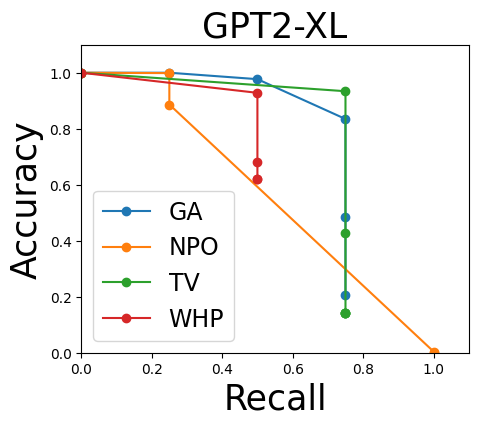

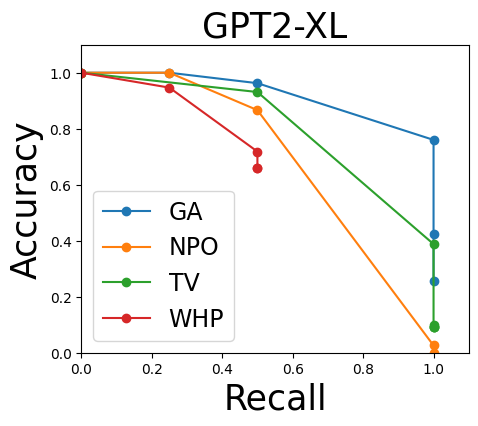

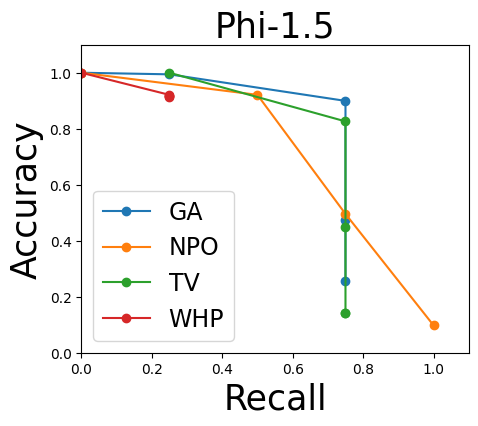

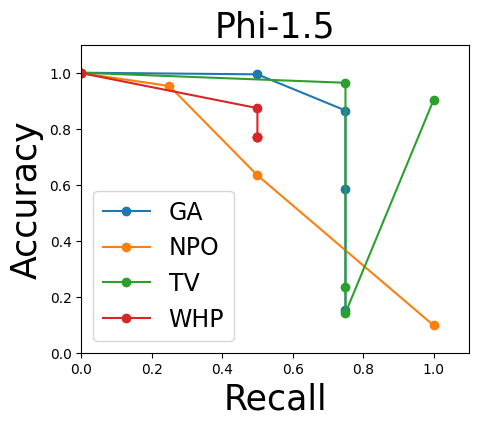

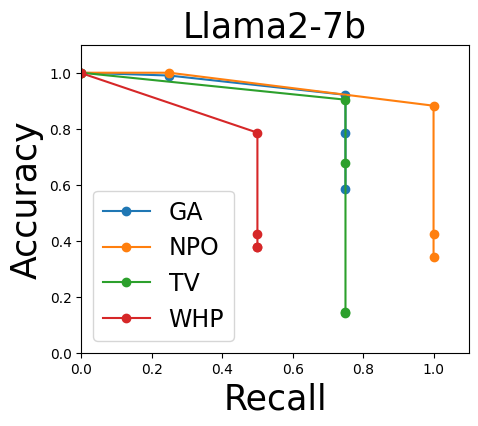

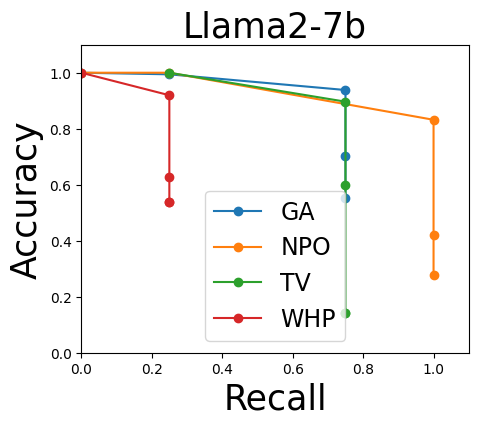

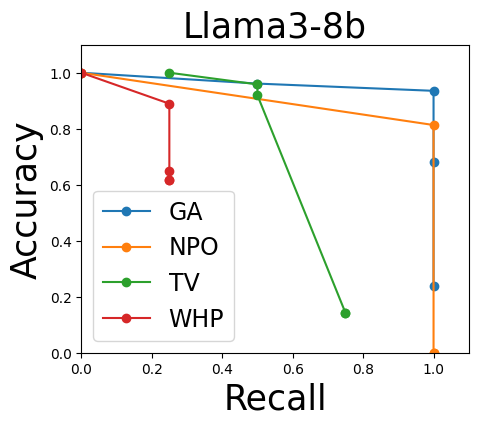

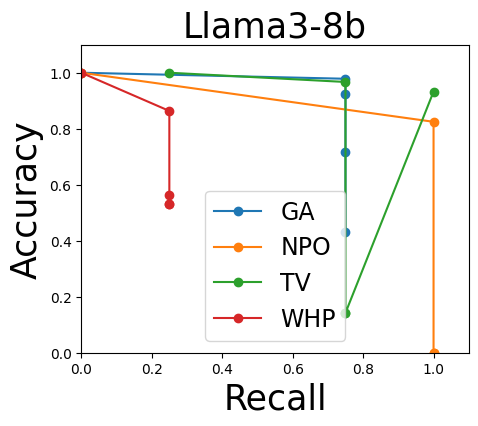

In [37]:
y_axis_list = ["Accuracy"] #, "Precision"
eval_name = "correct_rephrase"
#unlearn_data_id_list
unlearn_data_id = 1


for model_name in model_name_list:
    for y_axis in y_axis_list:
        for unlearn_data_id in [0, 1]:
            plt.figure(figsize=(5, 4))
            color_i = 0

            for unlearn_method_name in unlearn_method_name_list:
                rec_list, prec_list, acc_list, att_acc_list, all_acc_list, target_unlearn_list = result_dict[(model_name, unlearn_method_name, unlearn_data_id, eval_name, search_name)]
                    
                if y_axis == "Accuracy":
                    y = all_acc_list
                else:
                    y = prec_list

                plt.plot(rec_list, y, marker="o", c=color_list[color_i], label=f"{presented_name[unlearn_method_name]}")#label=r"$U_{M, k}^*$" + f" ({search_name})"
                color_i += 1
            plt.xlabel("Recall", fontsize=fontsize)
            plt.ylabel(y_axis, fontsize=fontsize)
            plt.title(f"{presented_name[model_name]}", fontsize=fontsize) #, eval_name, search_name
            plt.legend(fontsize=fontsize-8)
            plt.xlim(0, 1.1)
            plt.ylim(0, 1.1)
            plt.savefig(f"result_figures/acc_rec_curve_{model_name}.pdf", bbox_inches='tight')
#             plt.show()
        

# for y_axis in y_axis_list:
#     for unlearn_data_id in [unlearn_data_id]:
#         plt.figure(figsize=(7, 4))
#         color_i = 0
#         for model_name in model_name_list:
#             for unlearn_method_name in unlearn_method_name_list:
#                 rec_list, prec_list, acc_list, att_acc_list, all_acc_list, target_unlearn_list = result_dict[(model_name, unlearn_method_name, unlearn_data_id, eval_name, search_name)]
                    
#                 if y_axis == "Accuracy":
#                     y = acc_list
#                 else:
#                     y = prec_list

#                 plt.scatter(rec_list, y, marker=marker_list[color_i], c=color_list[color_i], label=f"{presented_name[unlearn_method_name]} ({presented_name[model_name]})")#label=r"$U_{M, k}^*$" + f" ({search_name})"
#                 color_i += 1
#         plt.xlabel("Recall", fontsize=fontsize)
#         plt.ylabel(y_axis, fontsize=fontsize)
#         plt.title(f"Accuracy-Recall Curves of Unlearning Methods on LLMs (One Target Data)", fontsize=fontsize) #, eval_name, search_name
#         plt.legend()
#         plt.xlim(0)
#         plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 233488.58it/s]


gpt2-xl 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 249391.05it/s]


gpt2-xl 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 288358.40it/s]


gpt2-xl 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 295752.21it/s]


gpt2-xl 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 174103.18it/s]


phi 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 185887.77it/s]


phi 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 214592.30it/s]


phi 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 211639.19it/s]


phi 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 237088.10it/s]


llama2-7b 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 235635.06it/s]


llama2-7b 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 243340.42it/s]


llama2-7b 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 241556.77it/s]


llama2-7b 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 229996.73it/s]


llama3-8b 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 280640.78it/s]


llama3-8b 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 269179.37it/s]


llama3-8b 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 250746.43it/s]


llama3-8b 55


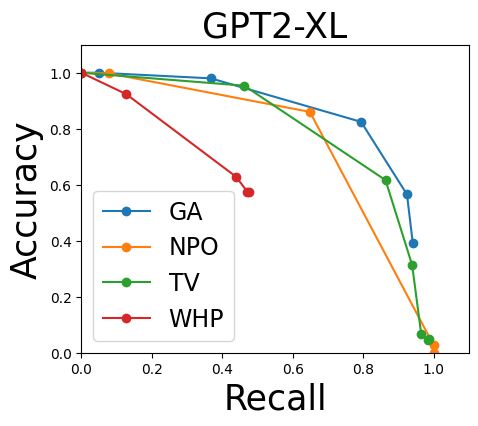

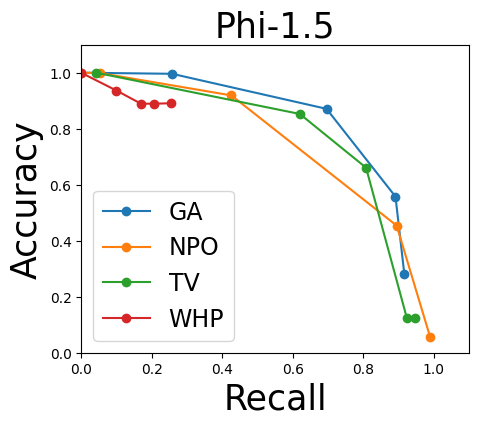

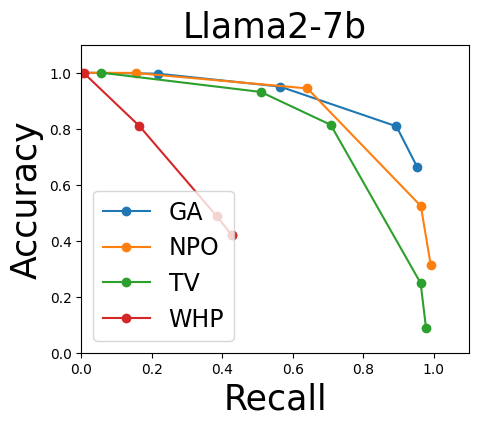

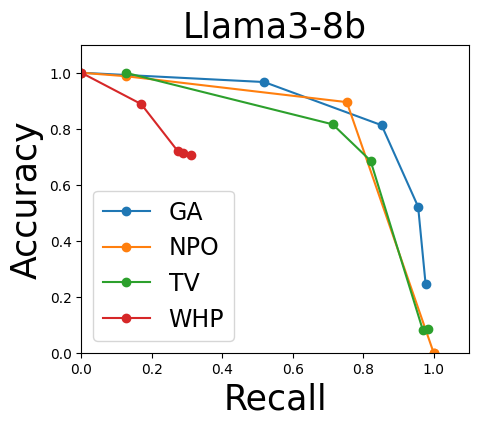

In [38]:
y_axis_list = ["Accuracy"] #, "Precision"
eval_name = "correct_rephrase"
required_len_list = [5, 5, 5, 5]
for model_name in model_name_list:
    for y_axis in y_axis_list:
        plt.figure(figsize=(5, 4))
        color_i = 0
        for unlearn_method_name, required_len in zip(unlearn_method_name_list, required_len_list):
            all_data_rec_list = []
            all_data_y_list = []
            for unlearn_data_id in tqdm(unlearn_data_id_list):
                rec_list, prec_list, acc_list, att_acc_list, all_acc_list, target_unlearn_list = result_dict[(model_name, unlearn_method_name, unlearn_data_id, eval_name, search_name)]
                if y_axis == "Accuracy":
                    y = all_acc_list
                else:
                    y = prec_list
                if len(rec_list) < required_len or len(y) < required_len:
                    continue
                all_data_rec_list.append(rec_list)
                all_data_y_list.append(y)
            print(model_name, len(all_data_rec_list))
            plt.plot(np.stack(all_data_rec_list).mean(0), np.stack(all_data_y_list).mean(0), marker="o", c=color_list[color_i], label=f"{presented_name[unlearn_method_name]}")#label=r"$U_{M, k}^*$" + f" ({search_name})"
            color_i += 1
        plt.xlabel("Recall", fontsize=fontsize)
        plt.ylabel(y_axis, fontsize=fontsize)
        plt.title(f"{presented_name[model_name]}", fontsize=fontsize) #, eval_name, search_name Average Curves on 
        plt.legend(fontsize=fontsize-8)
        plt.xlim(0, 1.1)
        plt.ylim(0, 1.1)
        plt.savefig(f"result_figures/acc_rec_curve_avg_{model_name}.pdf", bbox_inches='tight')
#         plt.show()

In [39]:
color_list = colormaps["tab10"].colors

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 41223.50it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 42429.05it/s]


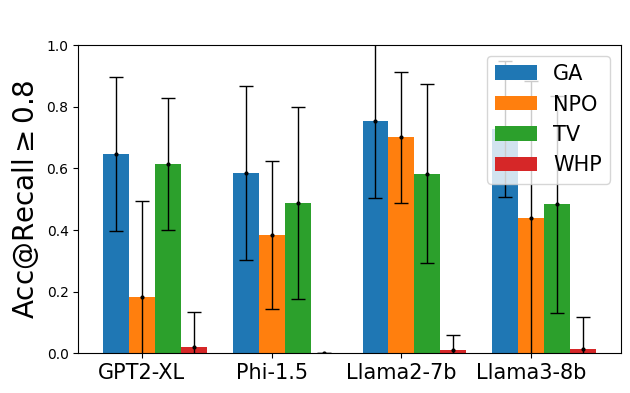

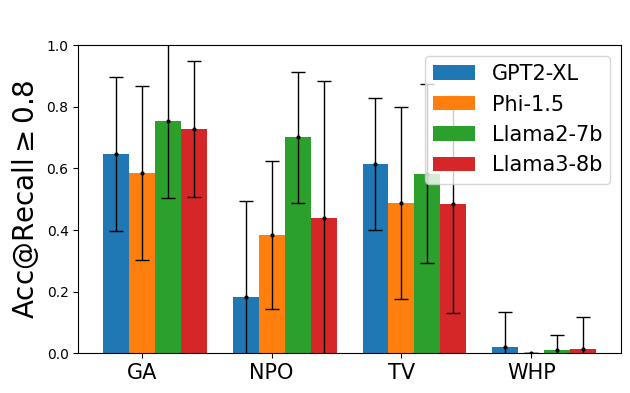

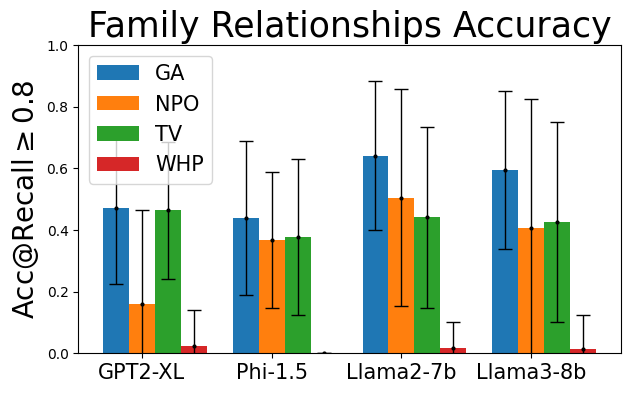

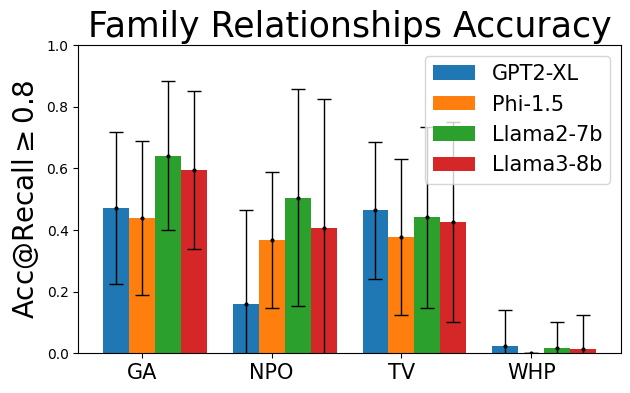

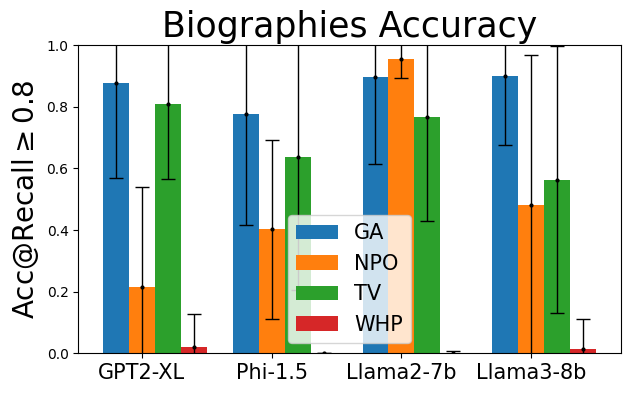

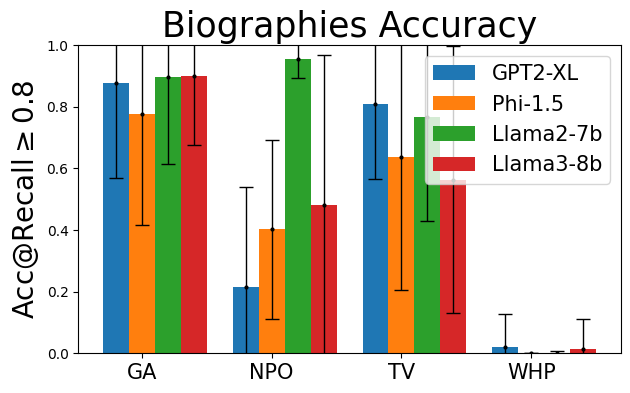

In [40]:
for y_axis in ["Accuracy", "Family Relationships Accuracy", "Biographies Accuracy"]:# , "Precision"
    eval_name = "correct_rephrase"
    required_len_list = [5, 5, 5, 5]
    for thr in [0.8]:
        all_model_all_unlearn_avg_acc_at_rec_list = []
        for model_name in model_name_list:
            all_unlearn_avg_acc_at_rec_list = []
            for unlearn_method_name, required_len in zip(unlearn_method_name_list, required_len_list):
                all_data_acc_at_rec_list = []
                for unlearn_data_id in tqdm(unlearn_data_id_list):
                    rec_list, prec_list, acc_list, att_acc_list, all_acc_list, target_unlearn_list = result_dict[(model_name, unlearn_method_name, unlearn_data_id, eval_name, search_name)]
                    if len(rec_list) < required_len:
                        print(unlearn_data_id, unlearn_method_name, model_name)
                        continue
                    if y_axis == "Family Relationships Accuracy":
                        y = acc_list
                        y = np.concatenate([np.ones(1), y, np.zeros(1)])
                    elif y_axis == "Biographies Accuracy":
                        y = att_acc_list
                        y = np.concatenate([np.ones(1), y, np.zeros(1)])
                    elif y_axis == "Accuracy":
                        y = all_acc_list
                        y = np.concatenate([np.ones(1), y, np.zeros(1)])
                    else:
                        print("not implemented")
                        print(1/0)
                    rec_list = np.concatenate([np.zeros(1), rec_list, np.ones(1)])
                    if thr is None:
                        all_data_acc_at_rec_list.append(auc(rec_list, y))
                    else:
                        all_data_acc_at_rec_list.append(y[rec_list >= thr].max())

                avg_acc_at_rec_list = (np.asarray(all_data_acc_at_rec_list).mean(), np.asarray(all_data_acc_at_rec_list).std())
                all_unlearn_avg_acc_at_rec_list.append(avg_acc_at_rec_list)
            all_model_all_unlearn_avg_acc_at_rec_list.append(all_unlearn_avg_acc_at_rec_list)
        all_model_all_unlearn_res = np.asarray(all_model_all_unlearn_avg_acc_at_rec_list)

        if thr is None:
            ylabel = f"AUCAR"
        else:
            ylabel = r"Acc@Recall$\geq$"+f"{thr}"

        plt.figure(figsize=(7, 4))
        for i, unlearn_method_name in enumerate(unlearn_method_name_list):
            plt.bar(np.arange(len(model_name_list)) + i/(len(unlearn_method_name_list)+1), all_model_all_unlearn_res[:, i, 0], label=f"{presented_name[unlearn_method_name]}", width=1/(len(unlearn_method_name_list)+1), color=color_list[i])
            plt.errorbar(np.arange(len(model_name_list)) + i/(len(unlearn_method_name_list)+1), all_model_all_unlearn_res[:, i, 0], yerr=all_model_all_unlearn_res[:, i, 1], capsize=5, color='Black', elinewidth=1, capthick=1, errorevery=1, ms=4, fmt='.')
        plt.xticks(np.arange(len(model_name_list))+0.2, [presented_name[model_name] for model_name in model_name_list], rotation=0, fontsize=fontsize-10)
    #     plt.xlabel("Models", fontsize=fontsize)
        plt.ylim(0, 1)
        plt.ylabel(ylabel, fontsize=fontsize-5)
        plt.legend(fontsize=fontsize-10)
        if y_axis == "Accuracy":
            plt.title(" ", fontsize=fontsize)
        else:
            plt.title(y_axis, fontsize=fontsize)
        if thr is None:
            plt.savefig(f"result_figures/aucar_{"_".join(y_axis.split(" "))}.pdf", bbox_inches='tight')
        else:
            plt.savefig(f"result_figures/acc_at_rec_{"_".join(y_axis.split(" "))}.pdf", bbox_inches='tight')
            
        plt.figure(figsize=(7, 4))
        for i, model_name in enumerate(model_name_list):
            plt.bar(np.arange(len(unlearn_method_name_list)) + i/(len(model_name_list)+1), all_model_all_unlearn_res[i, :, 0], label=f"{presented_name[model_name]}", width=1/(len(model_name_list)+1), color=color_list[i])
            plt.errorbar(np.arange(len(unlearn_method_name_list)) + i/(len(model_name_list)+1), all_model_all_unlearn_res[i, :, 0], yerr=all_model_all_unlearn_res[i, :, 1], capsize=5, color='Black', elinewidth=1, capthick=1, errorevery=1, ms=4, fmt='.')
        plt.xticks(np.arange(len(unlearn_method_name_list))+0.2, [presented_name[unlearn_method_name] for unlearn_method_name in unlearn_method_name_list], rotation=0, fontsize=fontsize-10)
    #     plt.xlabel("Models", fontsize=fontsize)
        plt.ylim(0, 1)
        plt.ylabel(ylabel, fontsize=fontsize-5)
        plt.legend(fontsize=fontsize-10)
        if y_axis == "Accuracy":
            plt.title(" ", fontsize=fontsize)
        else:
            plt.title(y_axis, fontsize=fontsize)
        if thr is None:
            plt.savefig(f"result_figures/aucar_{"_".join(y_axis.split(" "))}_transpose.pdf", bbox_inches='tight')
        else:
            plt.savefig(f"result_figures/acc_at_rec_{"_".join(y_axis.split(" "))}_transpose.pdf", bbox_inches='tight')
#         plt.show()

#     plt.figure(figsize=(7, 4))
#     for i, unlearn_method_name in enumerate(unlearn_method_name_list):
#         plt.plot(np.arange(len(model_name_list)), all_model_all_unlearn_res[:, i, 0], label=f"{presented_name[unlearn_method_name]}", marker="o")
#         plt.errorbar(np.arange(len(model_name_list)), all_model_all_unlearn_res[:, i, 0], yerr=all_model_all_unlearn_res[:, i, 1], capsize=5, color='Black', elinewidth=1, capthick=1, errorevery=1, ms=4, fmt='.')
#     plt.xticks(np.arange(len(model_name_list)), [presented_name[model_name] for model_name in model_name_list], rotation=0, fontsize=fontsize-3)

# #     plt.xlabel("Models", fontsize=fontsize)
#     plt.ylim(0, 1)
#     plt.ylabel(ylabel, fontsize=fontsize)
#     plt.legend(fontsize=fontsize-3)
#     plt.title(y_axis, fontsize=fontsize)
#     plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 39528.22it/s]


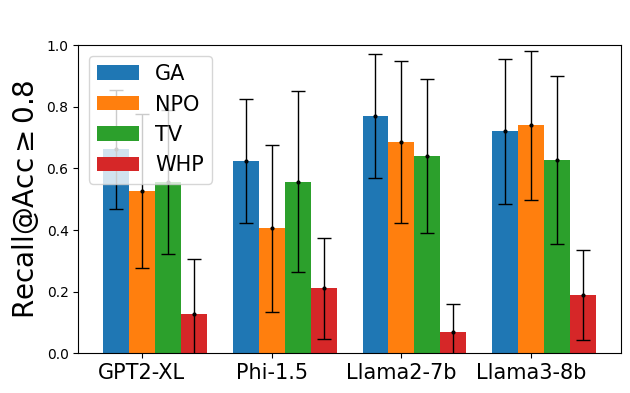

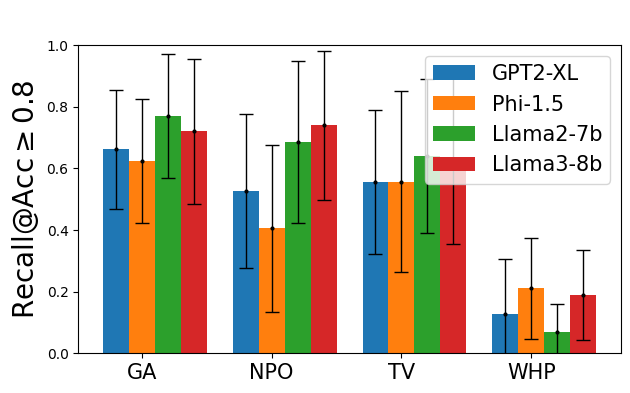

In [41]:
for y_axis in ["Accuracy"]:# , "Precision"
    eval_name = "correct_rephrase"
    required_len_list = [5, 5, 5, 5]
    for thr in [0.8]:
        all_model_all_unlearn_avg_acc_at_rec_list = []
        for model_name in model_name_list:
            all_unlearn_avg_acc_at_rec_list = []
            for unlearn_method_name, required_len in zip(unlearn_method_name_list, required_len_list):
                all_data_acc_at_rec_list = []
                for unlearn_data_id in tqdm(unlearn_data_id_list):
                    rec_list, prec_list, acc_list, att_acc_list, all_acc_list, target_unlearn_list = result_dict[(model_name, unlearn_method_name, unlearn_data_id, eval_name, search_name)]
                    if len(rec_list) < required_len:
                        print(unlearn_data_id, unlearn_method_name, model_name)
                        continue
                    if y_axis == "Family Relationships Accuracy":
                        y = acc_list
                        y = np.concatenate([np.ones(1), y, np.zeros(1)])
                    elif y_axis == "Biography Accuracy":
                        y = att_acc_list
                        y = np.concatenate([np.ones(1), y, np.zeros(1)])
                    elif y_axis == "Accuracy":
                        y = all_acc_list
                        y = np.concatenate([np.ones(1), y, np.zeros(1)])
                    else:
                        print("not implemented")
                        print(1/0)
                    rec_list = np.concatenate([np.zeros(1), rec_list, np.ones(1)])
                    all_data_acc_at_rec_list.append(rec_list[y >= thr].max())

                avg_acc_at_rec_list = (np.asarray(all_data_acc_at_rec_list).mean(), np.asarray(all_data_acc_at_rec_list).std())
                all_unlearn_avg_acc_at_rec_list.append(avg_acc_at_rec_list)
            all_model_all_unlearn_avg_acc_at_rec_list.append(all_unlearn_avg_acc_at_rec_list)
        all_model_all_unlearn_res = np.asarray(all_model_all_unlearn_avg_acc_at_rec_list)

        if thr is None:
            ylabel = f"AUCAR"
        else:
            ylabel = r"Recall@Acc$\geq$"+f"{thr}"

        plt.figure(figsize=(7, 4))
        for i, unlearn_method_name in enumerate(unlearn_method_name_list):
            plt.bar(np.arange(len(model_name_list)) + i/(len(unlearn_method_name_list)+1), all_model_all_unlearn_res[:, i, 0], label=f"{presented_name[unlearn_method_name]}", width=1/(len(unlearn_method_name_list)+1), color=color_list[i])
            plt.errorbar(np.arange(len(model_name_list)) + i/(len(unlearn_method_name_list)+1), all_model_all_unlearn_res[:, i, 0], yerr=all_model_all_unlearn_res[:, i, 1], capsize=5, color='Black', elinewidth=1, capthick=1, errorevery=1, ms=4, fmt='.')
        plt.xticks(np.arange(len(model_name_list))+0.2, [presented_name[model_name] for model_name in model_name_list], rotation=0, fontsize=fontsize-10)
    #     plt.xlabel("Models", fontsize=fontsize)
        plt.ylim(0, 1)
        plt.ylabel(ylabel, fontsize=fontsize-5)
        plt.legend(fontsize=fontsize-10)
        if y_axis == "Accuracy":
            plt.title(" ", fontsize=fontsize)
        else:
            plt.title(y_axis, fontsize=fontsize)
#         plt.title(y_axis, fontsize=fontsize)
        plt.savefig(f"result_figures/rec_at_acc_{"_".join(y_axis.split(" "))}.pdf", bbox_inches='tight')
#         plt.show()


        plt.figure(figsize=(7, 4))
        for i, model_name in enumerate(model_name_list):
            plt.bar(np.arange(len(unlearn_method_name_list)) + i/(len(model_name_list)+1), all_model_all_unlearn_res[i, :, 0], label=f"{presented_name[model_name]}", width=1/(len(model_name_list)+1), color=color_list[i])
            plt.errorbar(np.arange(len(unlearn_method_name_list)) + i/(len(model_name_list)+1), all_model_all_unlearn_res[i, :, 0], yerr=all_model_all_unlearn_res[i, :, 1], capsize=5, color='Black', elinewidth=1, capthick=1, errorevery=1, ms=4, fmt='.')
        plt.xticks(np.arange(len(unlearn_method_name_list))+0.2, [presented_name[unlearn_method_name] for unlearn_method_name in unlearn_method_name_list], rotation=0, fontsize=fontsize-10)
    #     plt.xlabel("Models", fontsize=fontsize)
        plt.ylim(0, 1)
        plt.ylabel(ylabel, fontsize=fontsize-5)
        plt.legend(fontsize=fontsize-10)
        if y_axis == "Accuracy":
            plt.title(" ", fontsize=fontsize)
        else:
            plt.title(y_axis, fontsize=fontsize)
        plt.savefig(f"result_figures/rec_at_acc_{"_".join(y_axis.split(" "))}_transpose.pdf", bbox_inches='tight')

#     plt.figure(figsize=(7, 4))
#     for i, unlearn_method_name in enumerate(unlearn_method_name_list):
#         plt.plot(np.arange(len(model_name_list)), all_model_all_unlearn_res[:, i, 0], label=f"{presented_name[unlearn_method_name]}", marker="o")
#         plt.errorbar(np.arange(len(model_name_list)), all_model_all_unlearn_res[:, i, 0], yerr=all_model_all_unlearn_res[:, i, 1], capsize=5, color='Black', elinewidth=1, capthick=1, errorevery=1, ms=4, fmt='.')
#     plt.xticks(np.arange(len(model_name_list)), [presented_name[model_name] for model_name in model_name_list], rotation=0, fontsize=fontsize-3)

# #     plt.xlabel("Models", fontsize=fontsize)
#     plt.ylim(0, 1)
#     plt.ylabel(ylabel, fontsize=fontsize)
#     plt.legend(fontsize=fontsize-3)
#     plt.title(y_axis, fontsize=fontsize)
#     plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 43046.60it/s]


(0.9843530331601528, 0.017015394182766007) [1.0, 1.0, 1.0, 1.0, 0.9885222381635581, 0.9884057971014493, 0.9956458635703919, 0.9710982658959537, 0.9782608695652174, 1.0, 0.9841954022988506, 1.0, 0.9724238026124818, 0.9784172661870504, 1.0, 0.9855491329479769, 0.9971181556195965, 0.9927745664739884, 0.9447674418604651, 0.9781976744186046, 0.9985549132947977, 0.9985549132947977, 0.9941860465116279, 0.9927325581395349, 0.9927953890489913, 0.9782293178519593, 0.978386167146974, 0.9434782608695652, 1.0, 0.9985632183908046, 0.9550724637681159, 0.911849710982659, 0.9840579710144928, 0.9666666666666667, 0.9594202898550724, 0.9927953890489913, 0.9726224783861671, 1.0, 0.9956521739130435, 0.9654178674351584, 0.9913294797687862, 0.9899135446685879, 0.9971098265895953, 0.9841040462427746, 1.0, 0.981159420289855, 0.9826839826839827, 0.9898550724637681, 0.978386167146974, 1.0, 0.9884393063583815, 0.9884393063583815, 0.9812409812409812, 0.9739884393063584, 0.9783549783549783]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 44819.65it/s]


(0.8142152669372944, 0.26403824743960475) [0.8864942528735632, 1.0, 0.9985632183908046, 0.9985652797704447, 0.8464849354375896, 0.004398826979472141, 0.7822931785195936, 0.8976945244956772, 0.8594202898550725, 0.9221902017291066, 1.0, 0.6947674418604651, 0.7590711175616836, 0.8848920863309353, 0.8175287356321839, 0.9971098265895953, 0.9985590778097982, 0.930635838150289, 0.8851744186046512, 0.7550432276657061, 1.0, 0.9277456647398844, 0.8674351585014409, 0.9121037463976945, 0.8604651162790697, 0.027859237536656877, 0.9005763688760807, 0.01608187134502924, 0.027298850574712645, 0.8575539568345324, 0.8318840579710145, 0.7281976744186046, 0.9028985507246376, 0.8666666666666667, 0.8869565217391304, 0.8717579250720461, 0.8559077809798271, 0.7521613832853026, 0.8130434782608695, 0.8703170028818443, 0.9985549132947977, 0.9971181556195965, 0.9985549132947977, 0.9219653179190751, 0.9985590778097982, 0.8739130434782608, 0.8253968253968254, 0.836231884057971, 0.8429394812680115, 0.002890173410404

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 44915.64it/s]


(0.9443542230461596, 0.054792875918767275) [0.9339080459770115, 0.9310344827586207, 0.9224137931034483, 0.9282639885222381, 0.9526542324246772, 0.9246376811594202, 0.9564586357039188, 0.8602305475504323, 0.9579710144927536, 0.8487031700288185, 0.9540229885057471, 0.9436416184971098, 0.965166908563135, 0.9568345323741008, 0.9425287356321839, 0.9797687861271677, 0.9769452449567724, 0.9739884393063584, 0.9913294797687862, 0.9607558139534884, 0.9215116279069767, 0.9595375722543352, 0.9941860465116279, 0.9767441860465116, 0.9694767441860465, 0.8289855072463768, 0.9495677233429395, 0.6536231884057971, 0.8850574712643678, 0.9798850574712644, 0.9420289855072463, 0.9017341040462428, 0.9289855072463769, 0.9565217391304348, 0.9590643274853801, 0.9870317002881844, 0.9582132564841499, 0.9596541786743515, 0.9898550724637681, 0.9610951008645533, 0.9812138728323699, 0.962536023054755, 0.9927745664739884, 0.9610951008645533, 0.9769452449567724, 0.9434782608695652, 0.950937950937951, 0.9521739130434783,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 45366.12it/s]


(0.6137860200151213, 0.2728094452709433) [0.9281609195402298, 0.9468390804597702, 0.9295977011494253, 0.7446197991391679, 0.6771879483500719, 0.6565217391304348, 0.0, 0.9595375722543352, 0.6432748538011696, 0.7312138728323699, 0.9367816091954023, 0.6206395348837209, 0.0, 0.576978417266187, 0.6738505747126436, 0.5939306358381503, 0.6143695014662757, 0.6200294550810015, 0.5036284470246735, 0.7046109510086456, 0.953757225433526, 0.9393063583815029, 0.6657060518731989, 0.6613372093023255, 0.7348703170028819, 0.0, 0.6080691642651297, 0.0, 0.9295977011494253, 0.0, 0.5599415204678363, 0.6705202312138728, 0.6376811594202898, 0.5898550724637681, 0.5478260869565217, 0.4147398843930636, 0.565028901734104, 0.9149855907780979, 0.47368421052631576, 0.5722543352601156, 0.5979680696661829, 0.9221902017291066, 0.5683139534883721, 0.6844380403458213, 0.9365994236311239, 0.5921052631578947, 0.0, 0.0, 0.7319884726224783, 0.9610951008645533, 0.638728323699422, 0.6729651162790697, 0.6927536231884058, 0.6170

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 46471.94it/s]


(0.97422374579116, 0.1344334642548796) [0.9942528735632183, 0.9942528735632183, 0.9870689655172413, 0.9827833572453372, 0.9827833572453372, 0.9927536231884058, 0.0, 0.9942196531791907, 0.9971014492753624, 1.0, 0.9956896551724138, 0.9841040462427746, 0.9970972423802612, 0.9884892086330935, 0.9942528735632183, 0.9956647398843931, 0.9971181556195965, 0.9942196531791907, 0.9956647398843931, 0.9971181556195965, 0.9985549132947977, 0.9985549132947977, 0.9971181556195965, 0.9971181556195965, 0.9971181556195965, 1.0, 0.9985590778097982, 0.836231884057971, 1.0, 0.9971264367816092, 0.9942028985507246, 1.0, 0.9565217391304348, 1.0, 0.9985507246376811, 1.0, 0.9985590778097982, 1.0, 1.0, 1.0, 0.9971098265895953, 0.9956772334293948, 0.9942196531791907, 0.9985590778097982, 0.9985590778097982, 0.9985507246376811, 0.9927849927849928, 1.0, 1.0, 0.9913294797687862, 0.9942196531791907, 0.9956647398843931, 0.9985611510791367, 0.9942196531791907, 1.0]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 47476.17it/s]


(0.6546696636387793, 0.3063328904400444) [0.9209770114942529, 0.9525862068965517, 1.0, 0.4146341463414634, 0.3787661406025825, 0.8855072463768116, 0.9796806966618288, 0.4653179190751445, 0.8449275362318841, 0.05346820809248557, 0.9956896551724138, 1.0, 0.9985486211901307, 0.19280575539568345, 0.05459770114942531, 0.3347826086956522, 0.3371757925072046, 0.5534682080924855, 0.22529069767441862, 0.2441860465116279, 0.9956011730205279, 0.622093023255814, 0.6816860465116279, 0.9781976744186046, 0.9855907780979827, 0.8272859216255443, 0.45809248554913296, 0.5246376811594203, 0.34770114942528735, 1.0, 0.3870967741935484, 0.9205202312138728, 0.35233918128654973, 0.34492753623188405, 0.5570175438596491, 0.37283236994219654, 0.9985590778097982, 0.7420749279538905, 0.9289855072463769, 0.49855907780979825, 0.8619186046511628, 0.22910662824207498, 0.20953757225433525, 1.0, 0.41786743515850144, 0.8840579710144928, 0.31693198263386396, 0.9159420289855073, 0.5835734870317003, 0.4048991354466859, 0.965

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 46378.51it/s]


(0.88597488807371, 0.14377707364126613) [1.0, 0.9640804597701149, 1.0, 0.9024390243902439, 0.7962697274031564, 0.6333333333333333, 0.21770682148040638, 0.6714697406340058, 0.5942028985507246, 0.8097982708933718, 1.0, 1.0, 0.9114658925979681, 1.0, 0.8635057471264368, 0.8517441860465116, 0.8590116279069767, 0.8909883720930233, 0.9450867052023122, 0.930835734870317, 0.953757225433526, 0.9552023121387283, 0.8242074927953891, 0.9171511627906976, 0.9265129682997119, 0.8625730994152047, 0.8789625360230547, 0.9751461988304093, 0.8491379310344828, 0.7844827586206896, 0.9391304347826087, 0.9364161849710982, 1.0, 0.9434782608695652, 0.9565217391304348, 0.9553314121037464, 0.8919308357348703, 0.9020172910662824, 0.9217391304347826, 0.9870317002881844, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7942028985507247, 0.5947901591895803, 0.9057971014492754, 0.8414985590778098, 0.5404624277456648, 1.0, 0.9378612716763006, 1.0, 0.9113372093023255, 1.0]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 47398.13it/s]


(0.7029385329847345, 0.3943998106000374) [0.9209770114942529, 0.8735632183908046, 0.9037356321839081, 0.8952654232424677, 0.9469153515064562, 0.9298245614035088, 0.0, 0.934971098265896, 0.8739130434782608, 0.7774566473988439, 0.9238505747126436, 0.9263005780346821, 0.0, 0.9223021582733812, 0.8936781609195402, 0.9927745664739884, 0.9884726224783862, 0.9898843930635838, 0.9739884393063584, 0.9553314121037464, 0.0, 0.0, 0.9538904899135446, 0.0, 0.9610951008645533, 0.0, 0.0, 0.0, 0.0, 0.9267241379310345, 0.8347826086956521, 0.8641618497109826, 0.7869565217391304, 0.8347826086956521, 0.0, 0.0, 0.9610951008645533, 0.946685878962536, 0.881159420289855, 0.9063400576368876, 0.9667630057803468, 0.9740634005763689, 0.9710982658959537, 0.9827089337175793, 0.968299711815562, 0.7792397660818714, 0.862914862914863, 0.0, 0.8414985590778098, 0.9538904899135446, 0.9653179190751445, 0.9624277456647399, 0.9640287769784173, 0.0, 0.9884892086330935]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 46369.19it/s]


(0.9855425331083528, 0.02330102847412414) [0.9899425287356322, 0.9942528735632183, 0.9956896551724138, 0.9870875179340028, 0.9971305595408895, 0.9942028985507246, 0.9985486211901307, 0.9971181556195965, 1.0, 0.9063400576368876, 1.0, 1.0, 1.0, 0.9985611510791367, 1.0, 0.9855491329479769, 0.9870317002881844, 0.9855491329479769, 0.9869942196531792, 0.9855907780979827, 0.9956647398843931, 0.9797687861271677, 0.9971181556195965, 0.9971181556195965, 1.0, 0.9521044992743106, 1.0, 0.946376811594203, 0.9022988505747126, 1.0, 0.9565217391304348, 0.9942196531791907, 0.9971014492753624, 0.972463768115942, 0.981159420289855, 0.962536023054755, 0.9985590778097982, 0.9971181556195965, 0.9985507246376811, 0.9582132564841499, 0.997093023255814, 1.0, 0.9985549132947977, 0.9971181556195965, 1.0, 0.991304347826087, 0.963924963924964, 1.0, 0.978386167146974, 0.9106628242074928, 0.998546511627907, 0.998546511627907, 1.0, 0.9942196531791907, 1.0]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 45834.83it/s]


(0.9101560068740732, 0.18549195853904815) [1.0, 1.0, 1.0, 0.9985652797704447, 1.0, 1.0, 0.9506531204644412, 0.9812680115273775, 0.5304347826086957, 0.7196531791907514, 1.0, 0.9956395348837209, 1.0, 1.0, 0.9985632183908046, 0.9638728323699421, 0.9985590778097982, 0.9725433526011561, 0.9971098265895953, 1.0, 0.9956647398843931, 0.9956647398843931, 0.9985590778097982, 0.9971181556195965, 0.9884726224783862, 0.9550072568940493, 0.9711815561959655, 0.9623188405797102, 0.4339080459770115, 0.5603448275862069, 0.7339181286549707, 0.9956647398843931, 0.991304347826087, 0.9753623188405797, 0.9478260869565217, 0.9985590778097982, 0.9985590778097982, 0.9971181556195965, 0.9333333333333333, 0.7442196531791907, 0.9505813953488372, 1.0, 0.5, 0.9337175792507204, 1.0, 1.0, 0.7359307359307359, 0.0, 0.8314121037463977, 0.9899135446685879, 0.9624277456647399, 0.9956647398843931, 0.9942446043165467, 0.8837209302325582, 1.0]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 46830.43it/s]


(0.9545909115334091, 0.09119157178029132) [0.9037356321839081, 1.0, 1.0, 1.0, 0.896700143472023, 1.0, 1.0, 0.9755043227665706, 0.9014492753623189, 0.9221902017291066, 1.0, 0.9291907514450867, 0.93033381712627, 0.9496402877697842, 0.8850574712643678, 0.9710982658959537, 0.9855907780979827, 1.0, 0.9825581395348837, 1.0, 1.0, 0.9898843930635838, 0.9767441860465116, 1.0, 0.9869186046511628, 0.9854862119013063, 0.8587896253602305, 0.9405797101449276, 0.8635057471264368, 0.8663793103448276, 0.9869565217391304, 1.0, 0.9521739130434783, 0.3713450292397661, 0.9855072463768116, 0.984149855907781, 1.0, 0.8890489913544669, 1.0, 0.9697406340057637, 0.9927325581395349, 0.9913544668587896, 1.0, 1.0, 1.0, 1.0, 0.9826839826839827, 0.9333333333333333, 0.829971181556196, 0.968299711815562, 0.9912790697674418, 0.9956395348837209, 0.9841726618705036, 0.9927745664739884, 1.0]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 45635.36it/s]


(0.5125036396274121, 0.3521969886989472) [0.7859195402298851, 0.9195402298850575, 0.8017241379310345, 0.763271162123386, 0.3486370157819226, 0.5248538011695907, 0.0, 0.0, 0.0, 0.0, 0.7341954022988506, 0.8020231213872833, 0.806966618287373, 0.8215827338129497, 0.8103448275862069, 0.9234104046242775, 0.9365994236311239, 0.9205202312138728, 0.9710982658959537, 0.9365994236311239, 0.0, 0.0, 0.0, 0.8198847262247838, 0.0, 0.0, 0.4479768786127168, 0.0, 0.6120689655172413, 0.5445402298850575, 0.0, 0.3808139534883721, 0.3592375366568915, 0.0, 0.0, 0.32803468208092484, 1.0, 0.8573487031700289, 0.48840579710144927, 0.3988439306358382, 0.9520348837209303, 0.7651296829971181, 0.7716763005780347, 0.8170028818443804, 0.7636887608069164, 0.4217391304347826, 0.417027417027417, 0.32898550724637676, 0.3645533141210375, 0.0, 0.5478645066273933, 0.6093979441997063, 0.720863309352518, 0.6632947976878613, 1.0]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 46500.04it/s]


(0.962894546213219, 0.03730952621361225) [0.9612068965517241, 0.978448275862069, 0.9755747126436781, 0.9655667144906743, 0.9784791965566715, 0.9666666666666667, 0.9985486211901307, 0.9337175792507204, 0.9434782608695652, 0.9827089337175793, 0.9770114942528736, 0.9624277456647399, 0.9680696661828737, 0.9654676258992806, 0.9741379310344828, 0.9680232558139535, 0.9697406340057637, 0.9520348837209303, 0.9781976744186046, 0.9510086455331412, 0.9898255813953488, 0.9898255813953488, 0.9927953890489913, 0.9942363112391931, 0.9941860465116279, 0.9680696661828737, 0.962536023054755, 0.9115942028985508, 0.9841954022988506, 0.7988505747126436, 0.9420289855072463, 0.9927745664739884, 0.7869565217391304, 0.9434782608695652, 0.9594202898550724, 0.9394812680115274, 0.9798270893371758, 0.984149855907781, 0.9434782608695652, 0.9409221902017291, 0.9783236994219653, 0.9740634005763689, 0.976878612716763, 0.958092485549133, 0.9826589595375722, 0.9884057971014493, 0.9696969696969697, 0.9840579710144928, 0.9

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 47701.97it/s]


(0.9224987308616944, 0.05030368947769334) [0.8132183908045977, 0.8247126436781609, 0.8218390804597702, 0.9325681492109039, 0.9110473457675753, 0.9130434782608695, 0.9375907111756169, 0.845821325648415, 0.9173913043478261, 0.9365994236311239, 0.8735632183908046, 0.8901734104046243, 0.9158200290275762, 0.9985611510791367, 0.9295977011494253, 0.9132947976878613, 0.9971181556195965, 0.9971098265895953, 1.0, 0.9971181556195965, 0.9219653179190751, 0.9219653179190751, 0.946685878962536, 0.9380403458213257, 0.9380403458213257, 0.8898550724637682, 0.9193083573487032, 0.908695652173913, 0.9985632183908046, 0.8563218390804598, 0.881159420289855, 0.880057803468208, 0.881159420289855, 0.881159420289855, 0.8797101449275362, 1.0, 1.0, 1.0, 0.8985507246376812, 0.9423631123919308, 0.9237536656891495, 0.9481268011527377, 0.9364161849710982, 0.9250720461095101, 0.9985590778097982, 0.9546783625730995, 0.8933717579250721, 0.9130434782608695, 0.9077809798270894, 0.9075144508670521, 0.811046511627907, 0.932

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 47349.49it/s]


(0.9582749197561348, 0.0788741049866859) [1.0, 1.0, 0.9382183908045977, 0.9354375896700143, 0.9512195121951219, 1.0, 0.9506531204644412, 1.0, 1.0, 0.9164265129682997, 0.9468390804597702, 0.9494219653179191, 1.0, 1.0, 1.0, 0.9287790697674418, 0.997093023255814, 0.9985549132947977, 1.0, 0.930835734870317, 0.9680232558139535, 0.9985549132947977, 0.9971181556195965, 0.9971181556195965, 0.9971181556195965, 1.0, 1.0, 1.0, 0.8721264367816092, 0.9985632183908046, 0.9420289855072463, 0.5947521865889213, 0.9449275362318841, 0.9434782608695652, 0.9347826086956522, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9447674418604651, 1.0, 0.934971098265896, 1.0, 1.0, 0.9840579710144928, 1.0, 0.8057971014492754, 1.0, 0.615606936416185, 0.9287790697674418, 0.9229651162790697, 0.9971223021582734, 0.9418604651162791, 0.9971223021582734]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 46165.04it/s]


(0.7121900495800054, 0.31122425466899595) [0.889367816091954, 0.8635057471264368, 0.9439655172413793, 0.8163558106169297, 0.6814921090387375, 0.8521739130434782, 0.5805515239477502, 0.8976945244956772, 0.8797101449275362, 0.4755043227665706, 0.8333333333333334, 0.8627167630057804, 0.7561683599419449, 0.9237410071942446, 0.9482758620689655, 0.0, 0.9827089337175793, 0.903179190751445, 0.726878612716763, 0.6095100864553314, 0.9552023121387283, 0.9378612716763006, 0.9510086455331412, 0.9553314121037464, 0.8976945244956772, 0.0, 0.8309248554913294, 0.8494152046783626, 0.8491379310344828, 0.0, 0.32456140350877194, 0.6011560693641619, 0.5260869565217391, 0.373900293255132, 0.8028985507246377, 0.9293948126801153, 0.8602305475504323, 0.8731988472622478, 0.9797101449275363, 0.978386167146974, 0.726878612716763, 0.8530259365994236, 0.6878612716763006, 0.9654178674351584, 0.9265129682997119, 0.5791788856304986, 0.0, 0.0, 0.7809798270893372, 0.0, 0.8372093023255814, 0.0, 0.9942446043165467, 0.92196

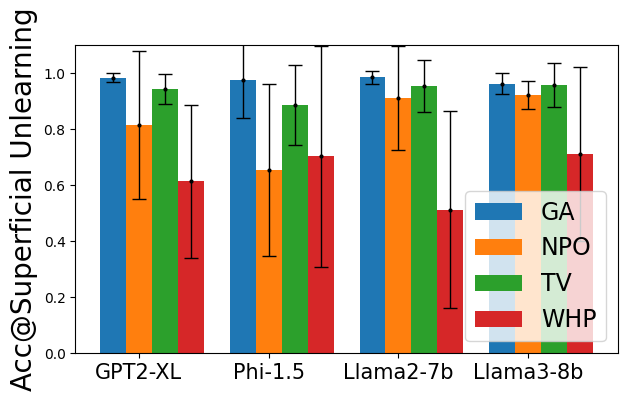

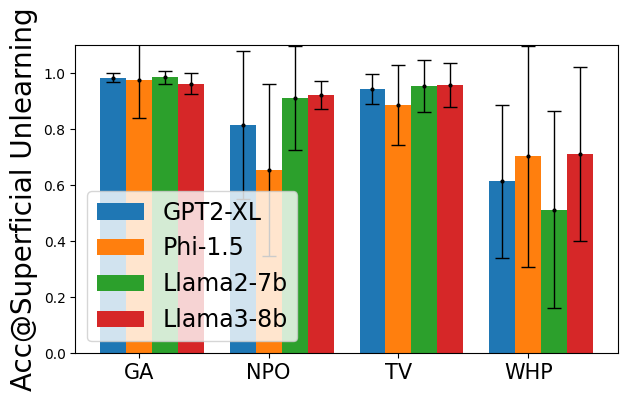

In [42]:
y_axis = "Accuracy" #"Family Relationships Accuracy"#"Biography Accuracy"# 
eval_name = "correct_rephrase"
required_len_list = [5, 5, 5, 5]
all_model_all_unlearn_avg_acc_at_rec_list = []
for model_name in model_name_list:
    all_unlearn_avg_acc_at_rec_list = []
    for unlearn_method_name, required_len in zip(unlearn_method_name_list, required_len_list):
        all_data_acc_at_rec_list = []
        for unlearn_data_id in tqdm(unlearn_data_id_list):
            rec_list, prec_list, acc_list, att_acc_list, all_acc_list, target_unlearn_list = result_dict[(model_name, unlearn_method_name, unlearn_data_id, eval_name, search_name)]
            if len(rec_list) < required_len:
                print(unlearn_data_id, unlearn_method_name, model_name)
                continue
            if y_axis == "Family Relationships Accuracy":
                y = acc_list
                y = np.concatenate([y, np.zeros(1)])
            elif y_axis == "Biography Accuracy":
                y = att_acc_list
                y = np.concatenate([y, np.zeros(1)])
            elif y_axis == "Accuracy":
                y = all_acc_list
                y = np.concatenate([y, np.zeros(1)])
            else:
                print("not implemented")
                print(1/0)
                
            target_unlearn_list = np.concatenate([target_unlearn_list, np.ones(1)])
            all_data_acc_at_rec_list.append(y[target_unlearn_list==1].max())
        avg_acc_at_rec_list = (np.asarray(all_data_acc_at_rec_list).mean(), np.asarray(all_data_acc_at_rec_list).std())
        print(avg_acc_at_rec_list, all_data_acc_at_rec_list)
        all_unlearn_avg_acc_at_rec_list.append(avg_acc_at_rec_list)
    all_model_all_unlearn_avg_acc_at_rec_list.append(all_unlearn_avg_acc_at_rec_list)
all_model_all_unlearn_res = np.asarray(all_model_all_unlearn_avg_acc_at_rec_list)


ylabel = "Acc@Superficial Unlearning"

plt.figure(figsize=(7, 4))
for i, unlearn_method_name in enumerate(unlearn_method_name_list):
    plt.bar(np.arange(len(model_name_list)) + i/(len(unlearn_method_name_list)+1), all_model_all_unlearn_res[:, i, 0], label=f"{presented_name[unlearn_method_name]}", width=1/(len(unlearn_method_name_list)+1), color=color_list[i])
    plt.errorbar(np.arange(len(model_name_list)) + i/(len(unlearn_method_name_list)+1), all_model_all_unlearn_res[:, i, 0], yerr=all_model_all_unlearn_res[:, i, 1], capsize=5, color='Black', elinewidth=1, capthick=1, errorevery=1, ms=4, fmt='.')
plt.xticks(np.arange(len(model_name_list))+0.2, [presented_name[model_name] for model_name in model_name_list], rotation=0, fontsize=fontsize-10)
# plt.xlabel("Models", fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize-5)
plt.ylim(0, 1.1)
plt.legend(fontsize=fontsize-8)
if y_axis == "Accuracy":
    plt.title(" ", fontsize=fontsize)
else:
    plt.title(y_axis, fontsize=fontsize)
plt.savefig(f"result_figures/acc_at_sup_unlearn.pdf", bbox_inches='tight')


plt.figure(figsize=(7, 4))
for i, model_name in enumerate(model_name_list):
    plt.bar(np.arange(len(unlearn_method_name_list)) + i/(len(model_name_list)+1), all_model_all_unlearn_res[i, :, 0], label=f"{presented_name[model_name]}", width=1/(len(model_name_list)+1), color=color_list[i])
    plt.errorbar(np.arange(len(unlearn_method_name_list)) + i/(len(model_name_list)+1), all_model_all_unlearn_res[i, :, 0], yerr=all_model_all_unlearn_res[i, :, 1], capsize=5, color='Black', elinewidth=1, capthick=1, errorevery=1, ms=4, fmt='.')
plt.xticks(np.arange(len(unlearn_method_name_list))+0.2, [presented_name[unlearn_method_name] for unlearn_method_name in unlearn_method_name_list], rotation=0, fontsize=fontsize-10)
#     plt.xlabel("Models", fontsize=fontsize)
plt.ylim(0, 1.1)
# plt.xlim(0, 1.1)
plt.ylabel(ylabel, fontsize=fontsize-5)
plt.legend(fontsize=fontsize-8)
if y_axis == "Accuracy":
    plt.title(" ", fontsize=fontsize)
else:
    plt.title(y_axis, fontsize=fontsize)
plt.savefig(f"result_figures/acc_at_sup_unlearn_transpose.pdf", bbox_inches='tight')

# plt.figure(figsize=(7, 4))
# for i, unlearn_method_name in enumerate(unlearn_method_name_list):
#     plt.plot(np.arange(len(model_name_list)), all_model_all_unlearn_res[:, i], label=f"{presented_name[unlearn_method_name]}", marker="o")

# plt.xticks(np.arange(len(model_name_list)), [presented_name[model_name] for model_name in model_name_list], rotation=0, fontsize=fontsize-3)

# plt.xlabel("Models", fontsize=fontsize)
# plt.ylabel(ylabel, fontsize=fontsize)
# plt.legend(fontsize=fontsize-3)
# plt.title(y_axis, fontsize=fontsize)
# plt.show()

In [43]:
y_axis = "Accuracy" #, "Precision"
eval_name = "correct_rephrase"
required_len_list = [5, 5, 5, 5]

thr = 0.8
print_res_list = []
for i, model_name in enumerate(model_name_list):
    print_res = presented_name[model_name] + " & "
    for i_thr, thr_type in enumerate(["acc@rec", "rec@acc"]):
        all_model_all_unlearn_avg_acc_at_rec_list = []
        for model_name in model_name_list:
            all_unlearn_avg_acc_at_rec_list = []
            for unlearn_method_name, required_len in zip(unlearn_method_name_list, required_len_list):
                all_data_acc_at_rec_list = []
                for unlearn_data_id in tqdm(unlearn_data_id_list):
                    rec_list, prec_list, acc_list, att_acc_list, all_acc_list, target_unlearn_list = result_dict[(model_name, unlearn_method_name, unlearn_data_id, eval_name, search_name)]
                    if len(rec_list) < required_len:
                        print(unlearn_data_id, unlearn_method_name, model_name)
                        continue
    #                 if thr is not None:
    #                     if (rec_list >= thr).sum() == 0:
    #                         print(unlearn_data_id, unlearn_method_name, model_name, rec_list.max())
    #                         continue
                    if y_axis == "Accuracy":
                        y = all_acc_list
                        y = np.concatenate([np.ones(1), y, np.zeros(1)])
                    else:
                        print("not implemented")
                        print(1/0)
                    rec_list = np.concatenate([np.zeros(1), rec_list, np.ones(1)])
                    if thr_type is None:
                        all_data_acc_at_rec_list.append(auc(rec_list, y))
                    elif thr_type == "acc@rec":
                        all_data_acc_at_rec_list.append(y[rec_list >= thr].max())
                    elif thr_type == "rec@acc":
                        all_data_acc_at_rec_list.append(rec_list[y >= thr].max())

                avg_acc_at_rec_list = np.asarray(all_data_acc_at_rec_list).mean()
                all_unlearn_avg_acc_at_rec_list.append(avg_acc_at_rec_list)
            all_model_all_unlearn_avg_acc_at_rec_list.append(all_unlearn_avg_acc_at_rec_list)
        all_model_all_unlearn_res = np.asarray(all_model_all_unlearn_avg_acc_at_rec_list)

        if i_thr  == 0:
            print_res = print_res + " & ".join(["{:.2f}".format(val) for val in all_model_all_unlearn_res[i]] + ["" for _ in range(4-len(all_model_all_unlearn_res[i]))]) + " & "
        else:
            print_res = print_res + " & ".join(["{:.2f}".format(val) for val in all_model_all_unlearn_res[i]] + ["" for _ in range(4-len(all_model_all_unlearn_res[i]))])
    print_res = print_res  + "\\\\"
    print_res_list.append(print_res)
for print_res in print_res_list:
    print(print_res)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 35473.89it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 37352.12it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 41640.20it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 40308.71it/s]

GPT2-XL & 0.65 & 0.18 & 0.61 & 0.02 & 0.66 & 0.53 & 0.56 & 0.13\\
Phi-1.5 & 0.59 & 0.38 & 0.49 & 0.00 & 0.62 & 0.41 & 0.56 & 0.21\\
Llama2-7b & 0.75 & 0.70 & 0.58 & 0.01 & 0.77 & 0.69 & 0.64 & 0.07\\
Llama3-8b & 0.73 & 0.44 & 0.48 & 0.01 & 0.72 & 0.74 & 0.63 & 0.19\\


In [44]:
print(len(person_list))

100


In [45]:
print_res_list

['GPT2-XL & 0.65 & 0.18 & 0.61 & 0.02 & 0.66 & 0.53 & 0.56 & 0.13\\\\',
 'Phi-1.5 & 0.59 & 0.38 & 0.49 & 0.00 & 0.62 & 0.41 & 0.56 & 0.21\\\\',
 'Llama2-7b & 0.75 & 0.70 & 0.58 & 0.01 & 0.77 & 0.69 & 0.64 & 0.07\\\\',
 'Llama3-8b & 0.73 & 0.44 & 0.48 & 0.01 & 0.72 & 0.74 & 0.63 & 0.19\\\\']